#Regression Models - Housing Data

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. The purpose of this experiment is to explore the data and prepare it to create, tune, and compare the performance of two predictive models.

In [0]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sqlalchemy import create_engine

from scipy.stats.mstats import winsorize
from scipy.stats import bartlett, levene

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import mse, rmse

# Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Set plot output to seaborn
sns.set()


In [0]:
# Define functions to be used for nulls, categorical data, and model grading
def model_scorer(y_test, y_predict, model_name='Model', metric=[]):
    """Given prediction (y_predict) and dependent variable (y_test) data,
    function returns calculated MAE, MSE, RMSE, and/or MAPE scores. Inputs:
    y_test - test data from dataset
    y_predict - model predictions of X_test data (should be shame shape as y_test)
    model_name - string input identifying the model; default is 'Model'
    metric - a list input specifying the desired metric or combination of metrics
             to calculate.  Will accept 'mae', 'mse', 'rmse', 'mape'; default
             is empty list that returns all calculations."""
    
    from statsmodels.tools.eval_measures import mse, rmse  
    from sklearn.metrics import mean_absolute_error
    
    error = y_test - y_predict
    
    a = mean_absolute_error(y_test, y_predict)
    b = mse(y_test, y_predict)
    c = rmse(y_test, y_predict)
    d = np.mean(np.abs(error)/(y_test)*100)
    
    metric_dict = {'mae':a, 'mse':b, 'rmse':c, 'mape':d}
    label_dict = {'mae':'Mean Absolute Error', 
                  'mse':'Mean Standard Error', 
                  'rmse':'Root Mean Squared Error', 
                  'mape':'Mean Absolute Percentage Error'}
    
    if len(metric)<1:
        print(f'------- {model_name} Model Eval. -------')
        print(f'Mean Absolute Error: {a}')
        print(f'Mean Standard Error:{b}')
        print(f'Root Mean Squared Error: {c}')
        print(f'Mean Absolute Percentage Error: {d}') 
    else:
        print(f'------- {model_name} Model Eval. -------')
        for m in metric:
            print(f'{label_dict[m]}:  {metric_dict[m]}')


# Load Data

In [0]:
# Database Credentials
user = 'dsbc_student'
pwrd = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
dtbs = 'houseprices'

In [0]:
# open engine
engine = create_engine(f'postgresql://{user}:{pwrd}@{host}:{port}/{dtbs}')

# Query database and read data into a dataframe
df = pd.read_sql_query('select * from houseprices',con=engine)

# Close connection to database
engine.dispose()

# Explore Data

In [0]:
df.head()

id  mssubclass mszoning  ...  saletype  salecondition saleprice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [0]:
df.describe()

id   mssubclass  ...       yrsold      saleprice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

In [0]:
df.describe(include='O')

mszoning street alley lotshape  ...  fence miscfeature saletype salecondition
count      1460   1460    91     1460  ...    281          54     1460          1460
unique        5      2     2        4  ...      4           4        9             6
top          RL   Pave  Grvl      Reg  ...  MnPrv        Shed       WD        Normal
freq       1151   1454    50      925  ...    157          49     1267          1198

[4 rows x 43 columns]

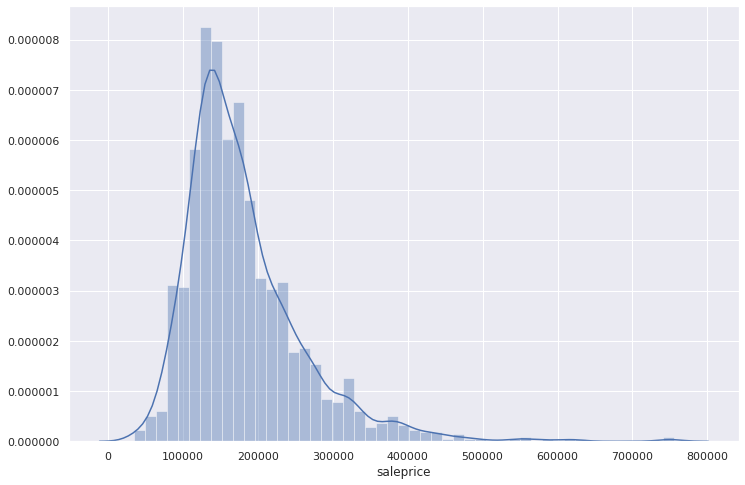

In [0]:
plt.figure(figsize=(12,8))
sns.distplot(df['saleprice'])
plt.show()

# Data Analysis

So far, the data set contains 80 potential features of mixed data types.  A large number of missing values are present.  Missing data could be reflective of erroneous recordkeeping/data entry, or it may indicate the absence of the home feature.  For example, null values for basement square footage may be present due to the home not having a basement.  Data will require more exploration to handle missing data.

Given the saleprice as the target, an initial look shows saleprice is skew right with extreme outliers present.  


In [0]:
# Look at features correlated with the target 
corr_w_target = (abs(df.corr()))['saleprice'].sort_values(ascending = False)[1:]
corr_w_target

overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
id               0.021917
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [0]:
corr_w_target[corr_w_target>0.1].index

Index(['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf',
       'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd',
       'garageyrblt', 'masvnrarea', 'fireplaces', 'bsmtfinsf1', 'lotfrontage',
       'wooddecksf', 'secondflrsf', 'openporchsf', 'halfbath', 'lotarea',
       'bsmtfullbath', 'bsmtunfsf', 'bedroomabvgr', 'kitchenabvgr',
       'enclosedporch', 'screenporch'],
      dtype='object')

Several features appear highly correlated with the target.  As these may be likely candidates for selection when building the model, they provide an excellent starting point for analysis.  Emphasis will be placed on features exceeding a 10% correlation, however, all features will be considered.

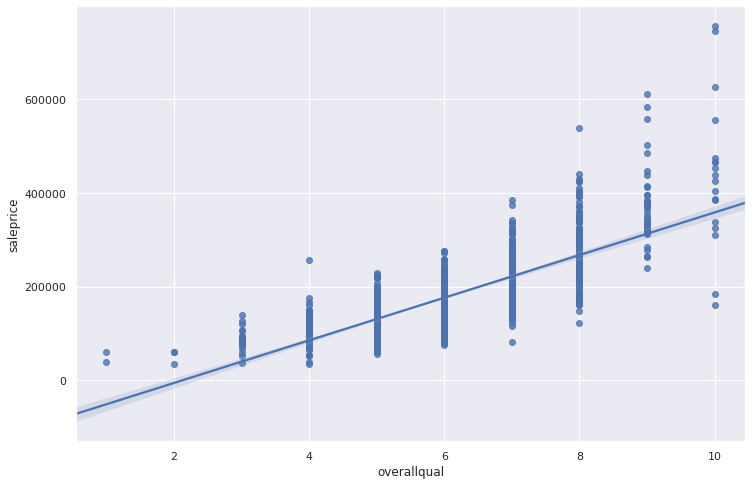

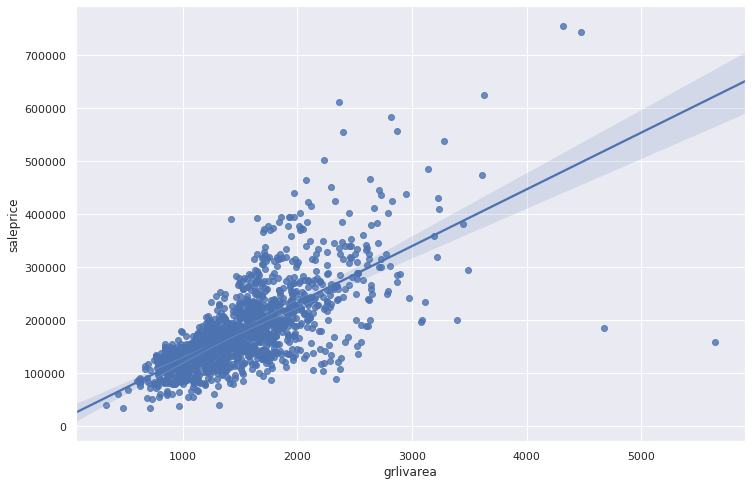

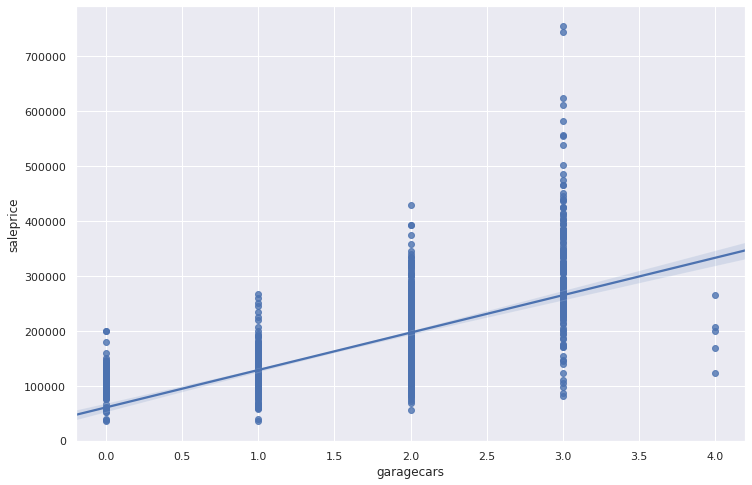

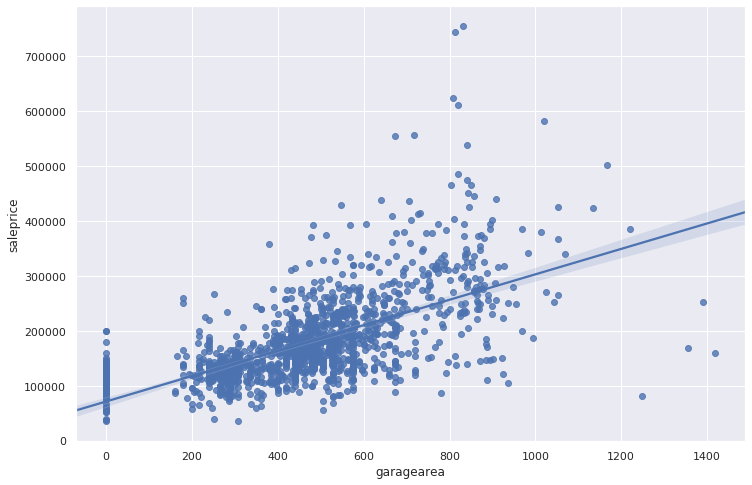

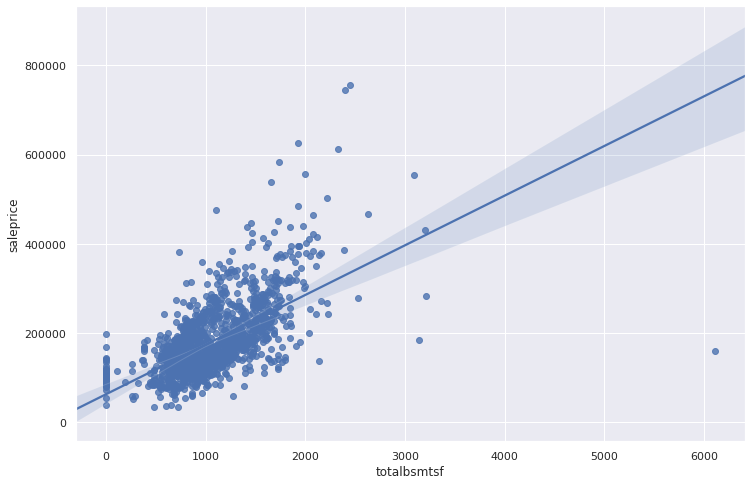

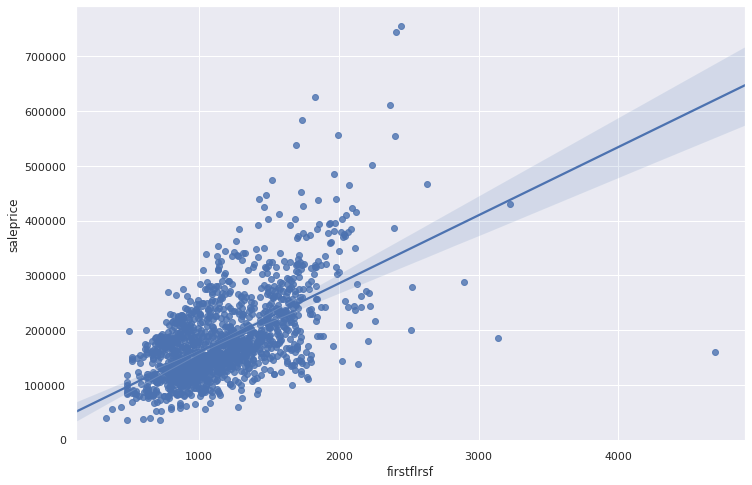

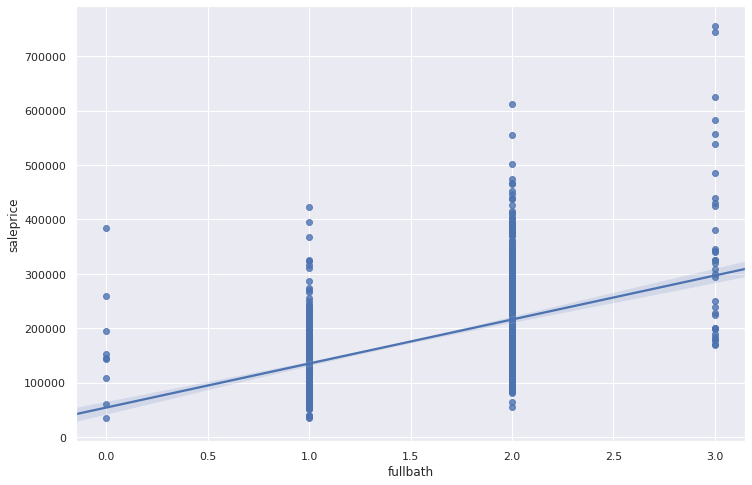

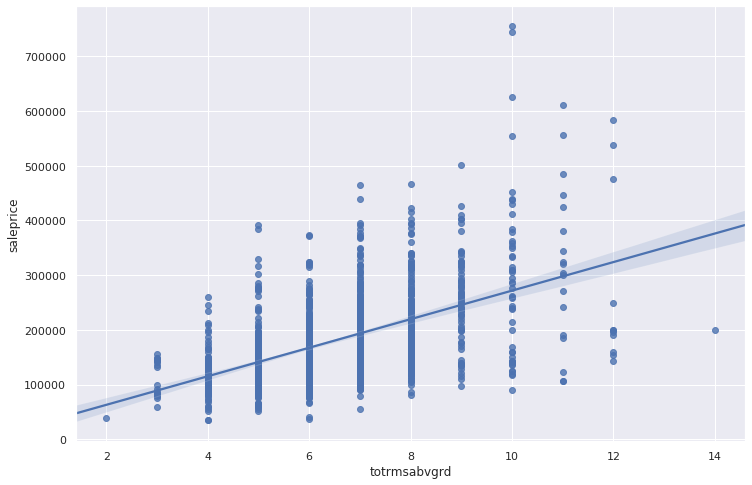

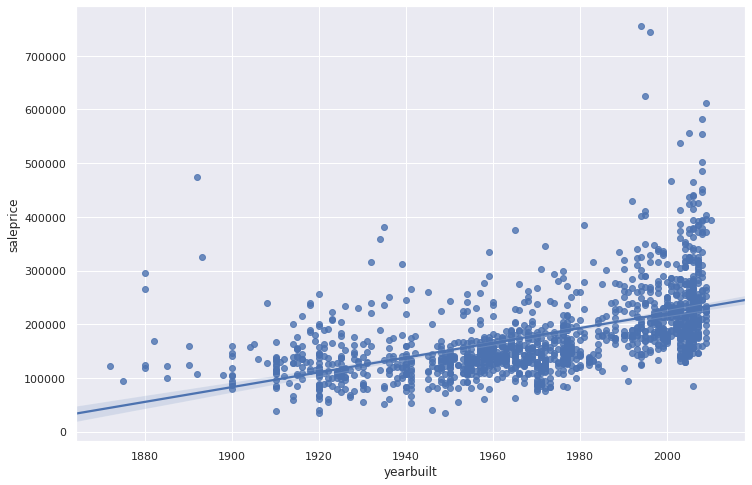

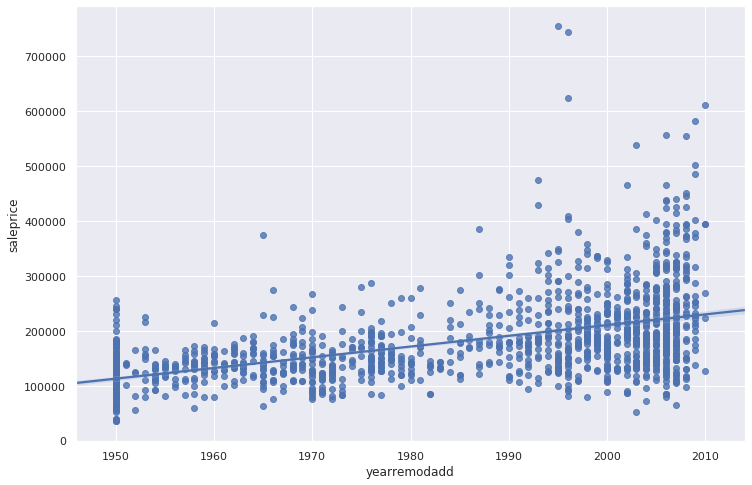

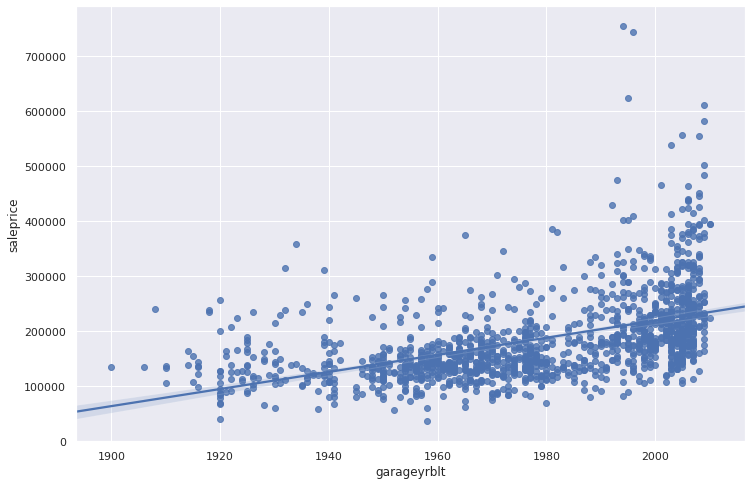

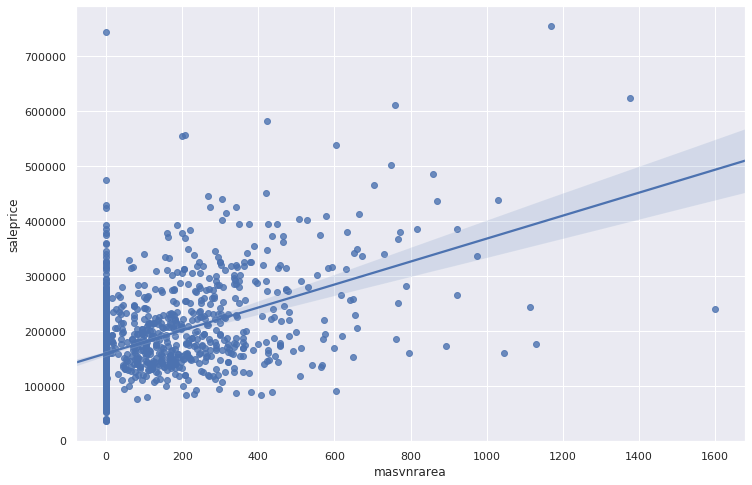

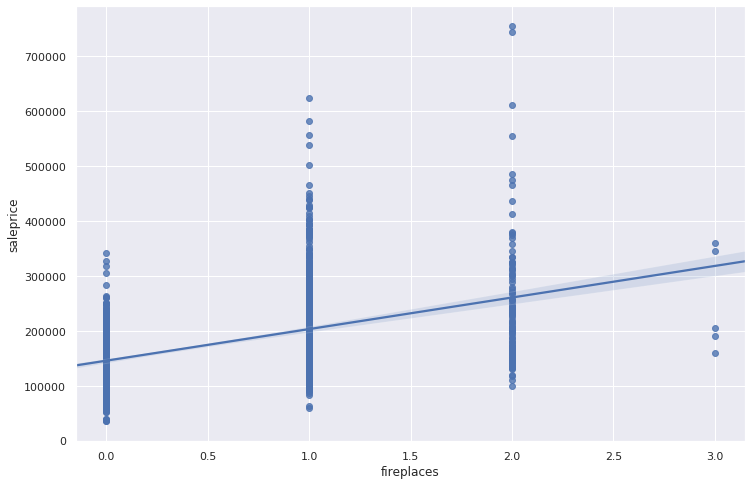

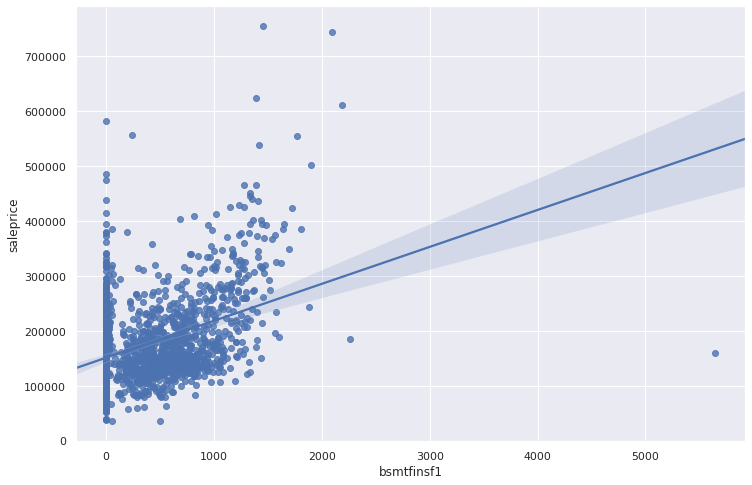

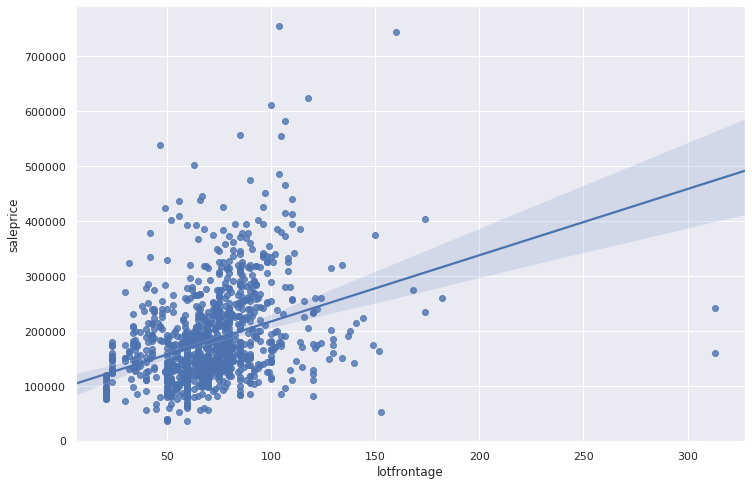

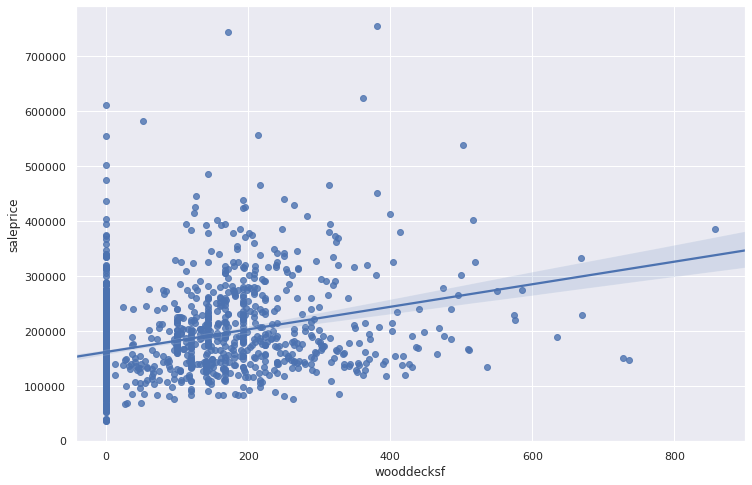

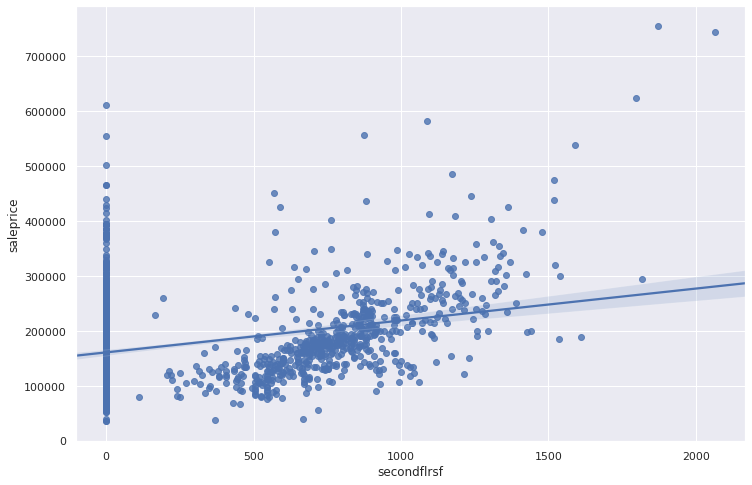

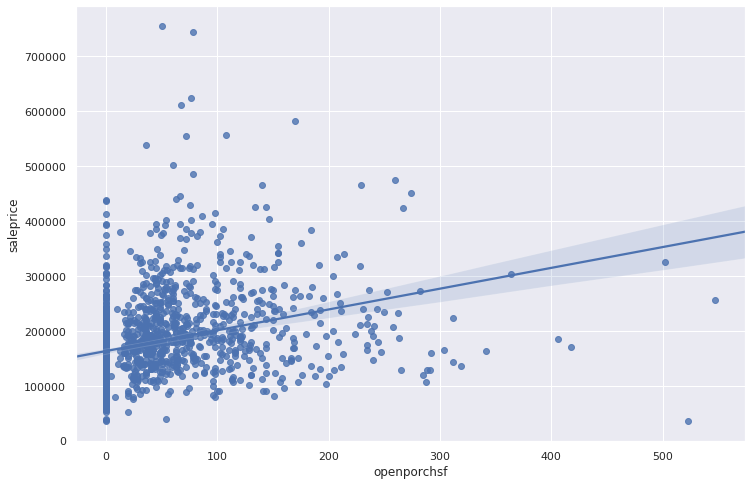

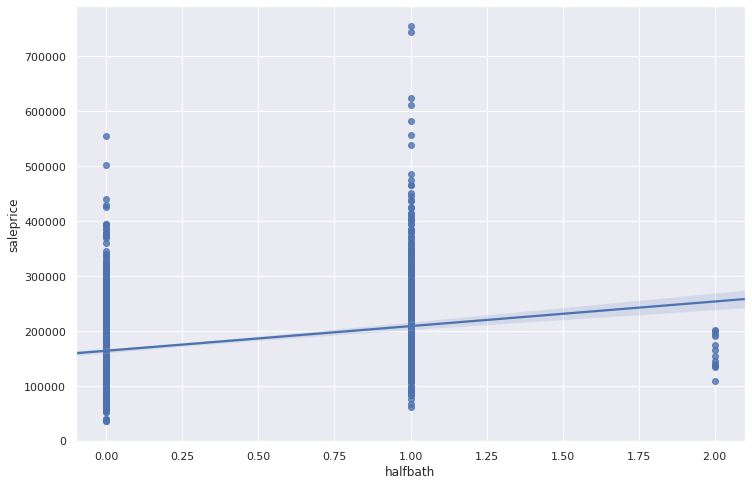

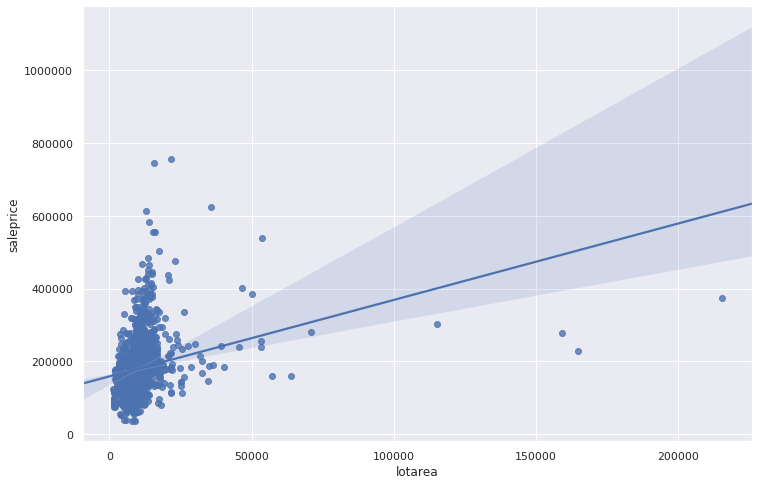

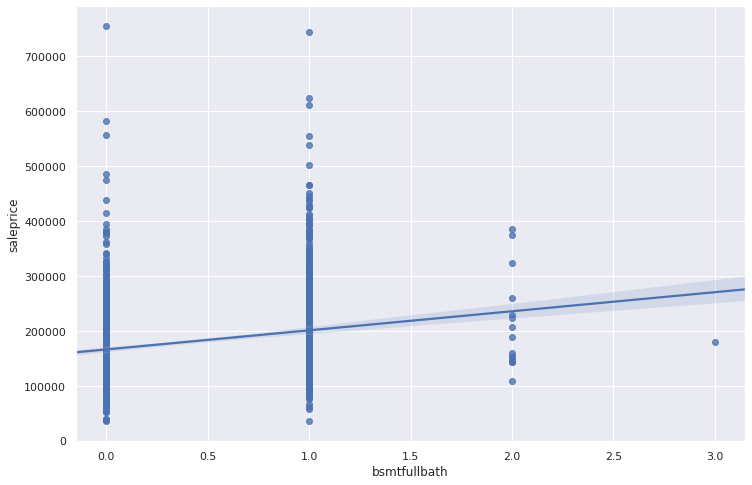

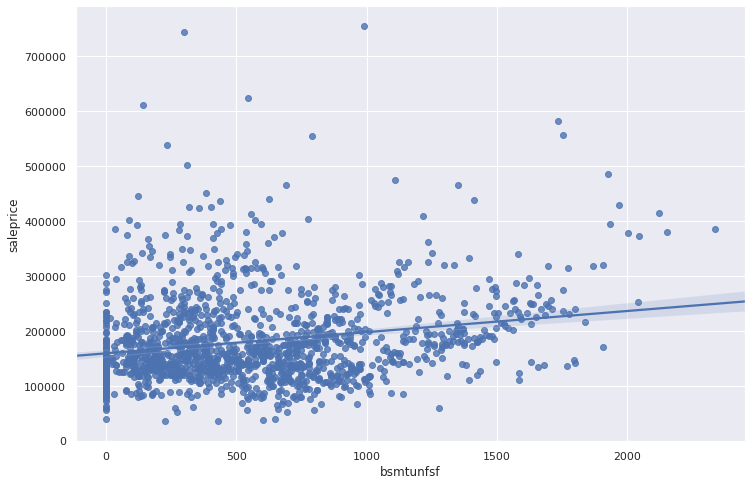

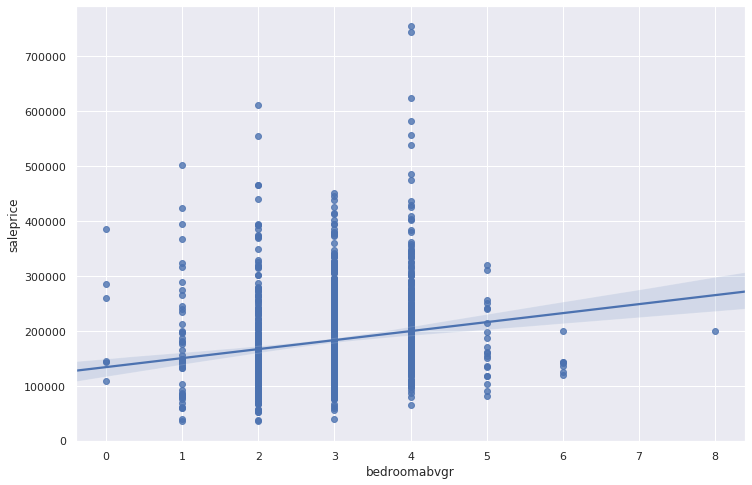

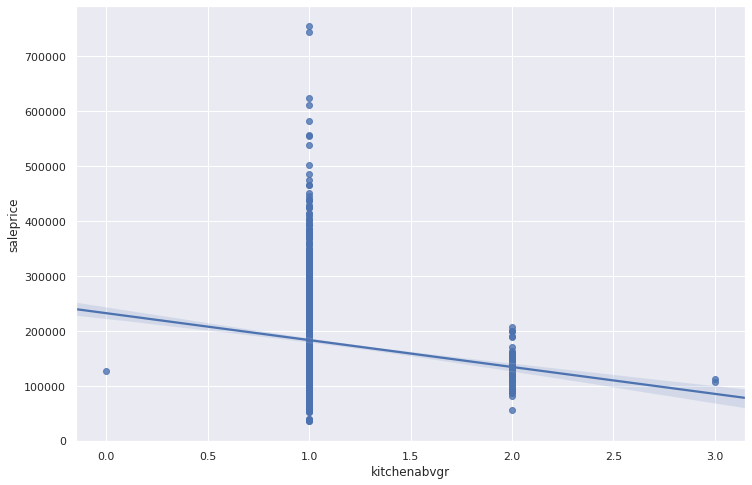

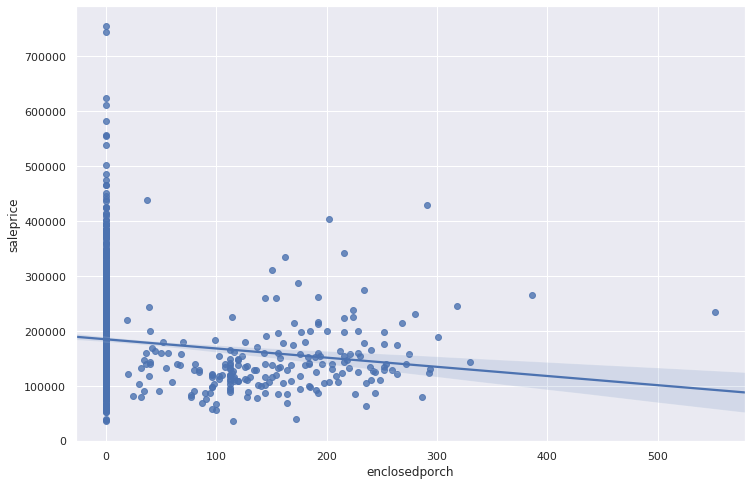

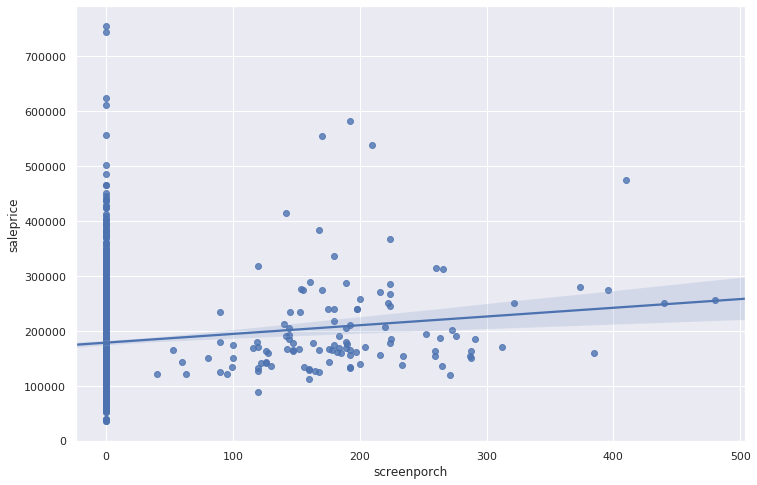

In [0]:
# Plot with reg plot to determine if a linear relationship might exists.
for column in corr_w_target[corr_w_target>0.1].index:
    plt.figure(figsize=(12,8))
    sns.regplot(df[column], df['saleprice'])
    plt.show()

These features vary between continuous and categorical.  In most cases, a positive correlation exists; as the occurence and/or degree of the feature increases, there is a subsequent increase in price.  The effect of each feature, as expected, varies by degree.  

Whereas an assumption for linear regression is that data must be homoscedastic, a residual plot of the features is run to assess this assumption.

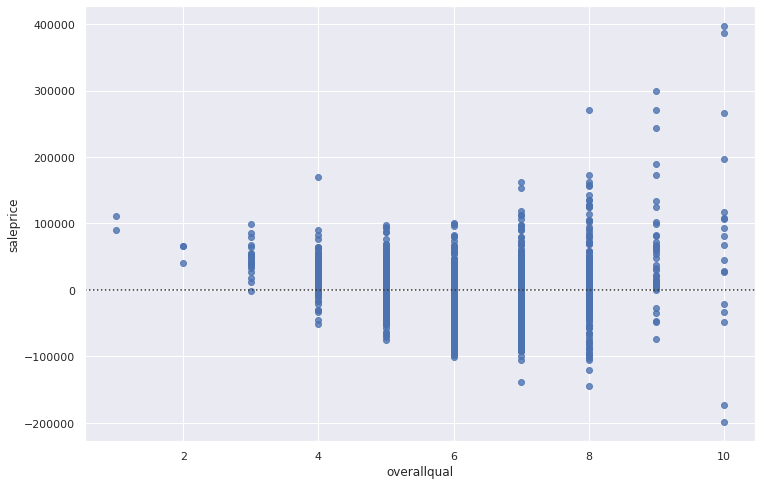

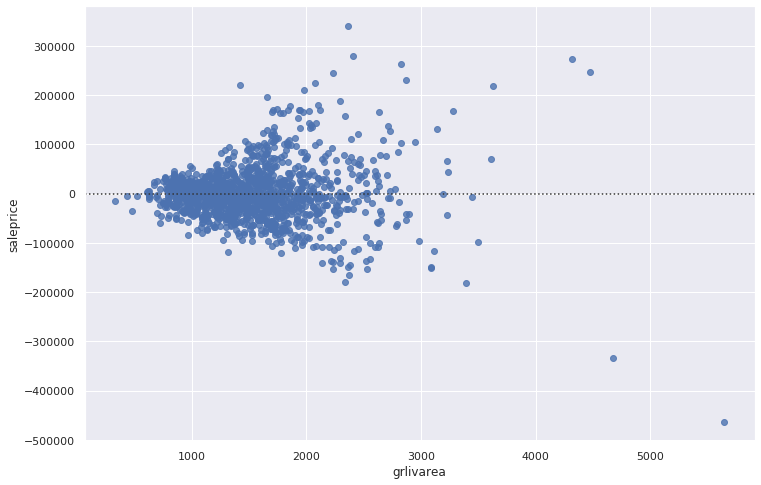

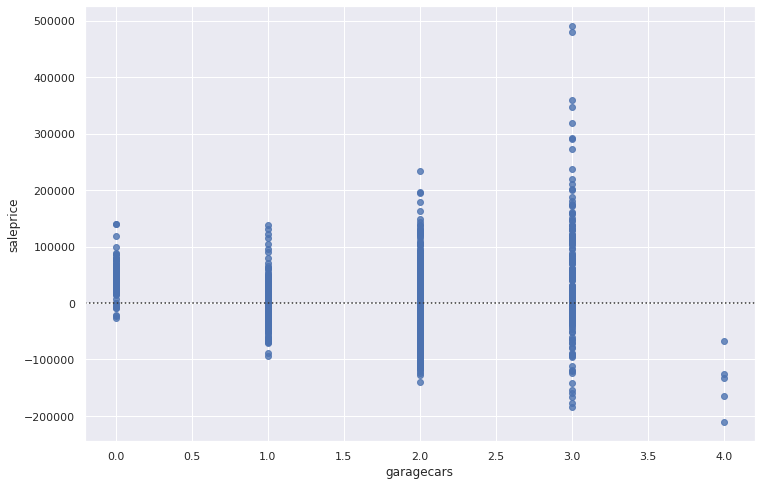

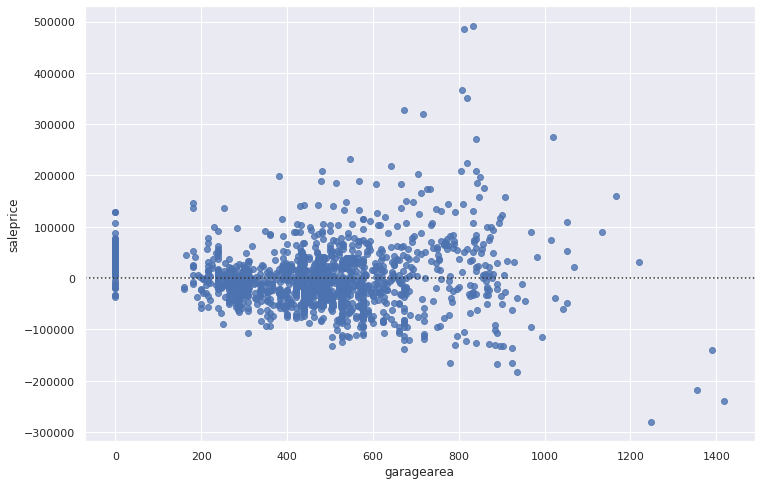

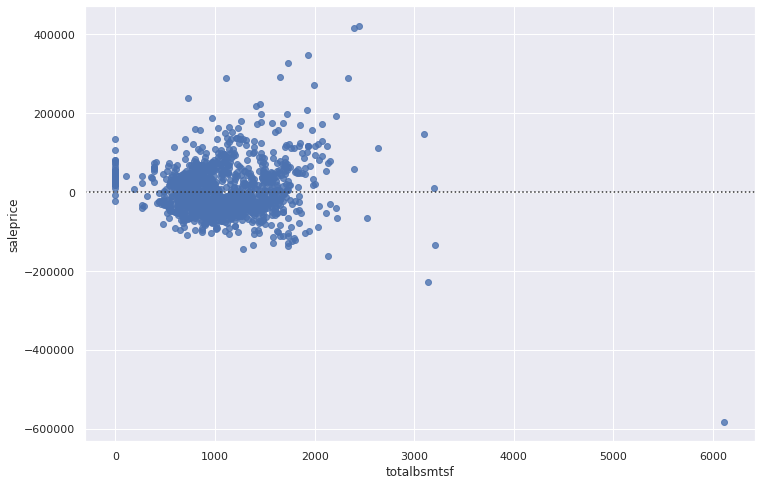

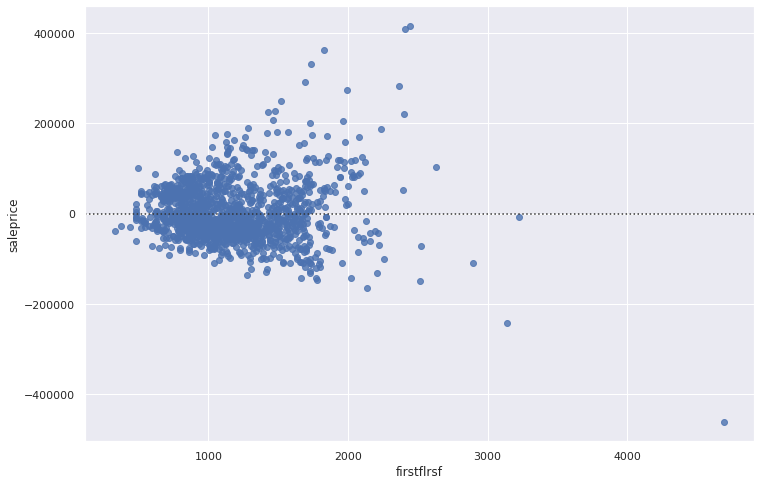

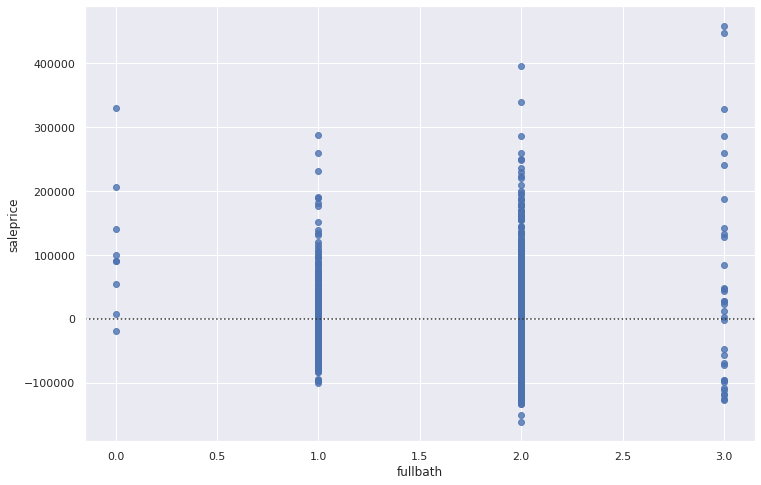

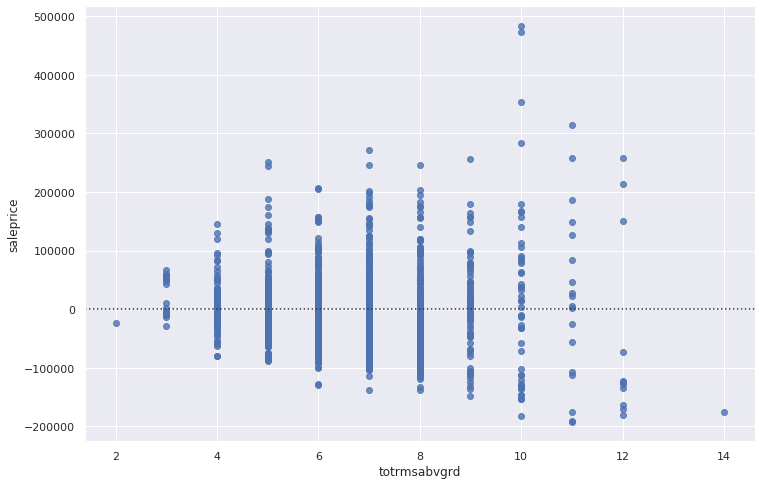

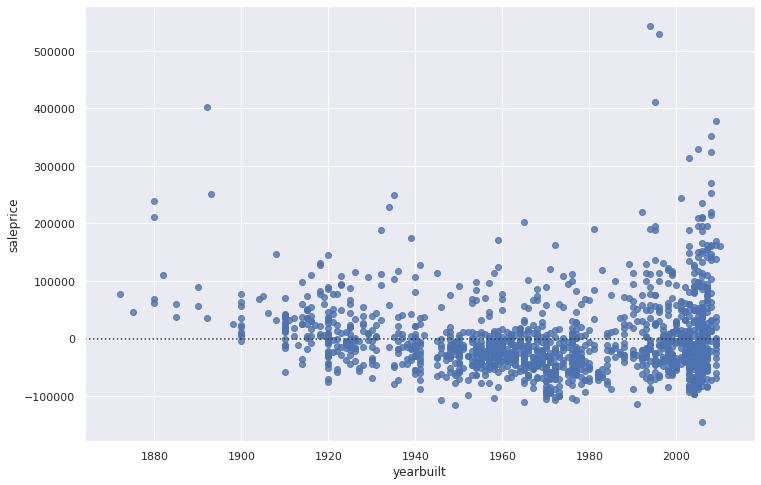

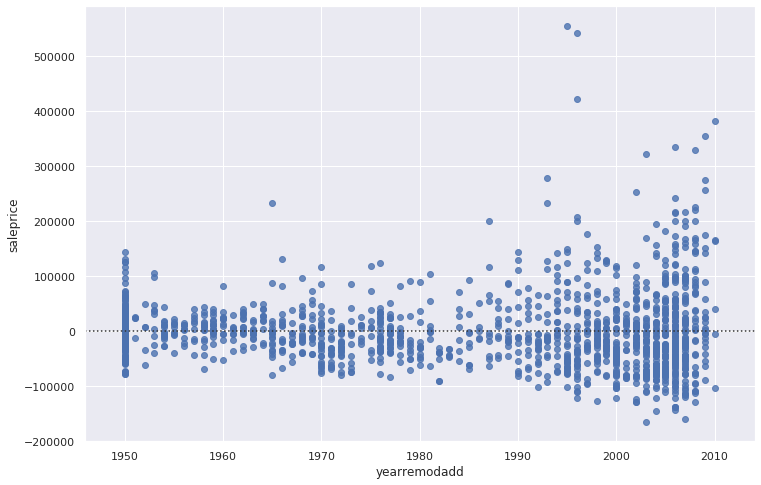

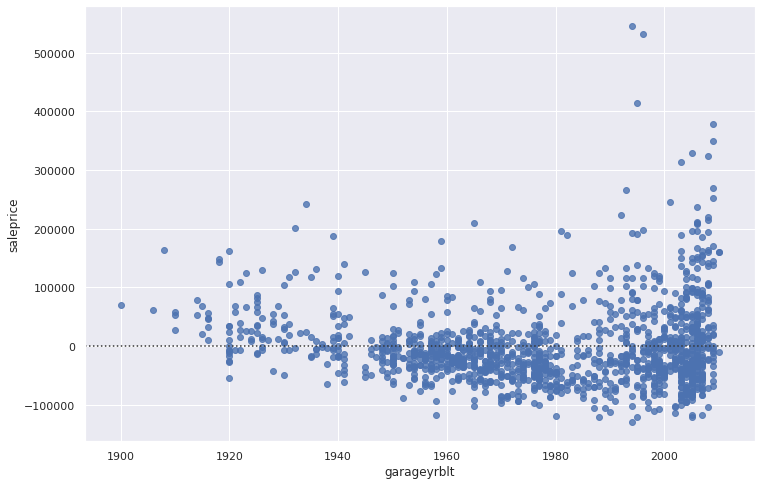

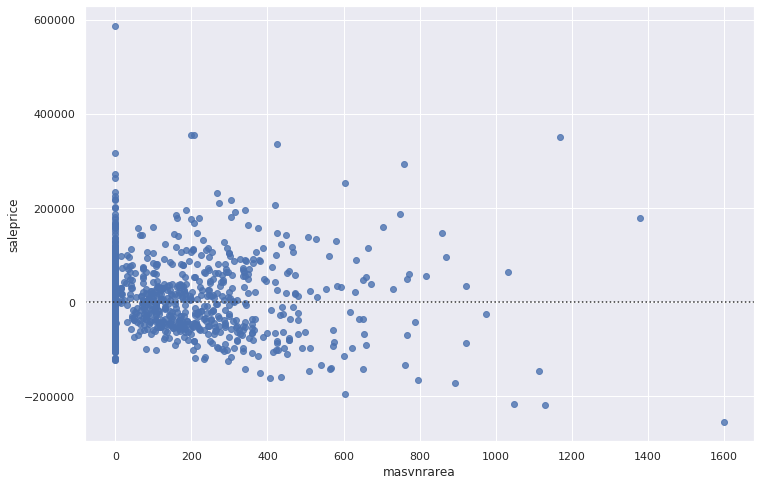

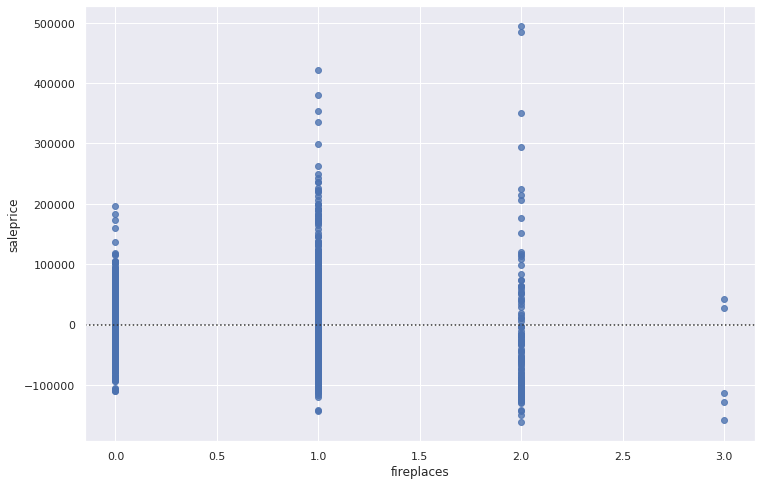

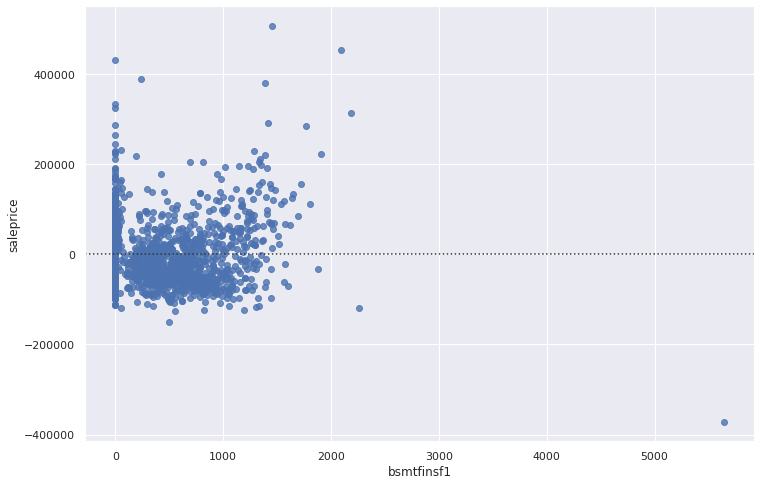

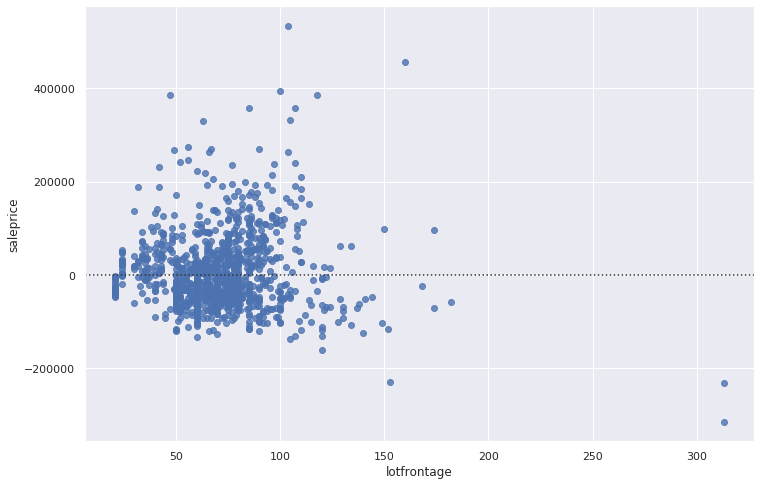

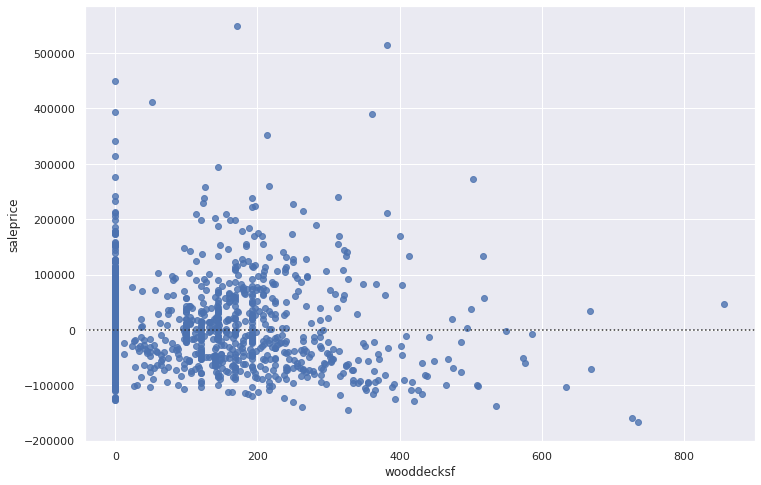

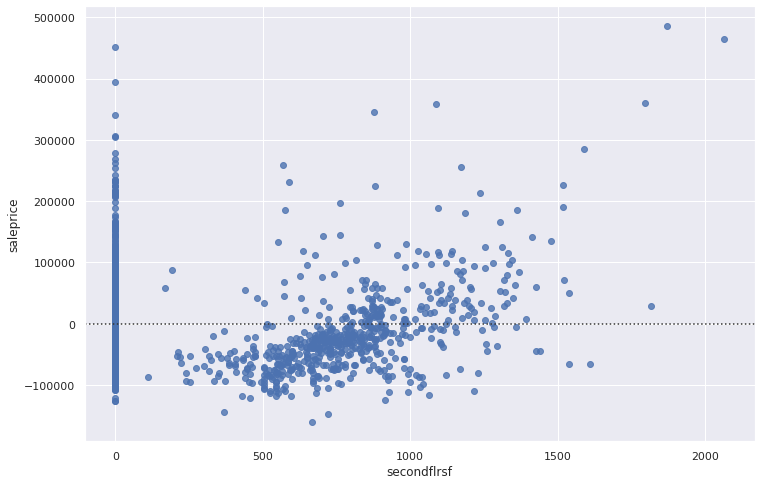

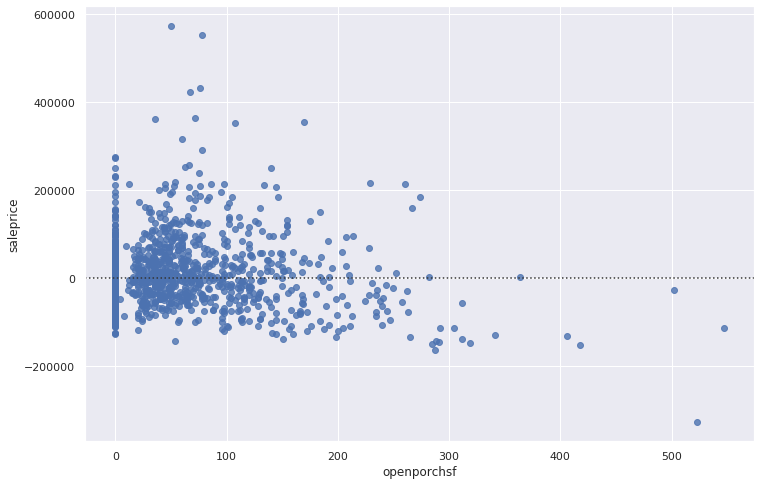

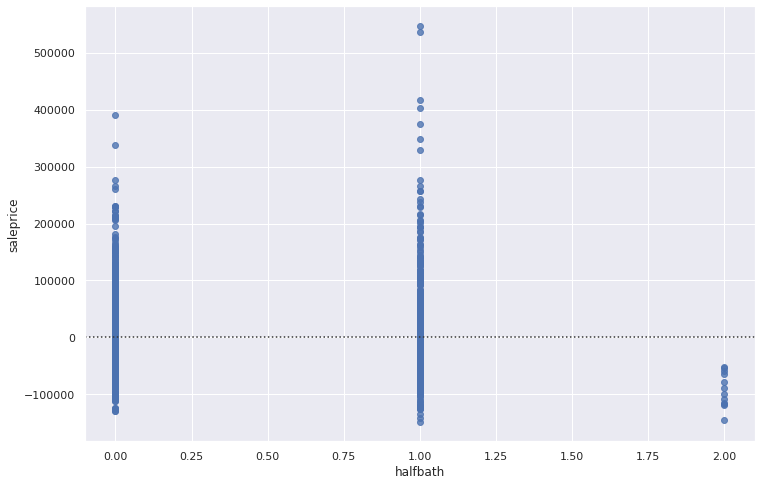

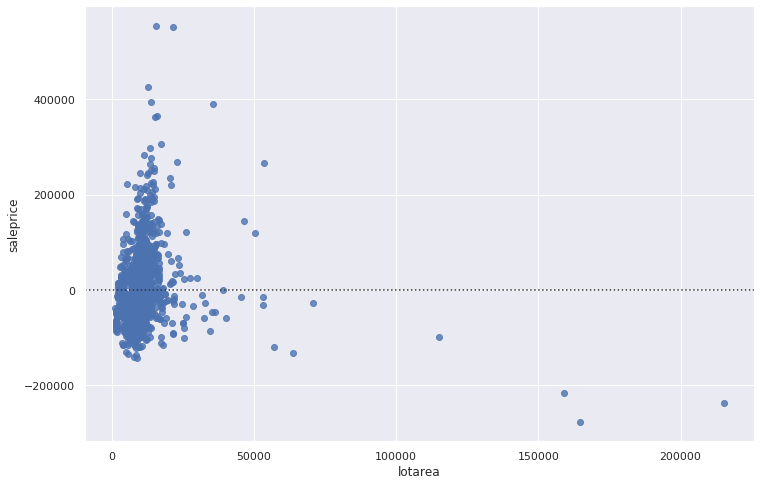

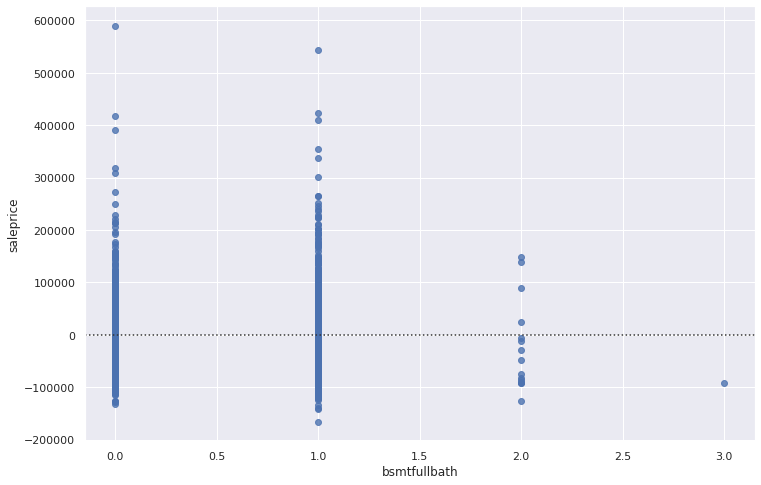

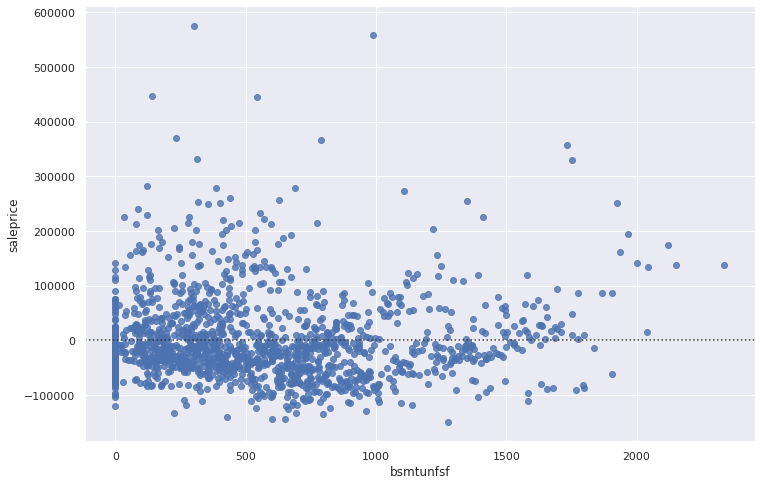

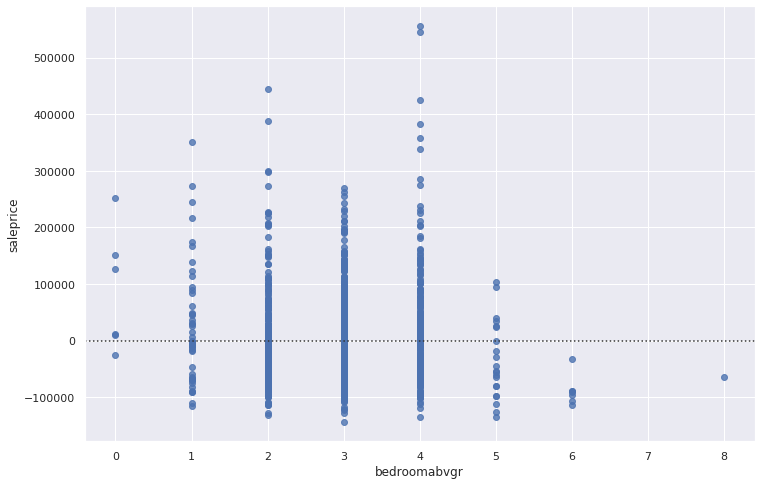

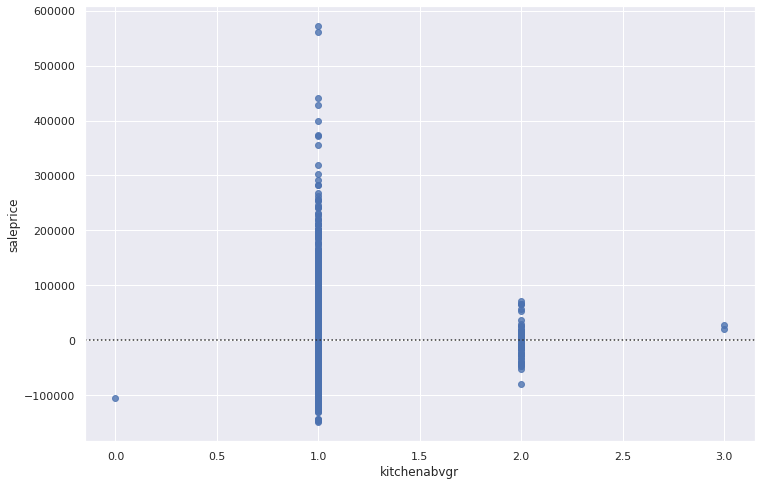

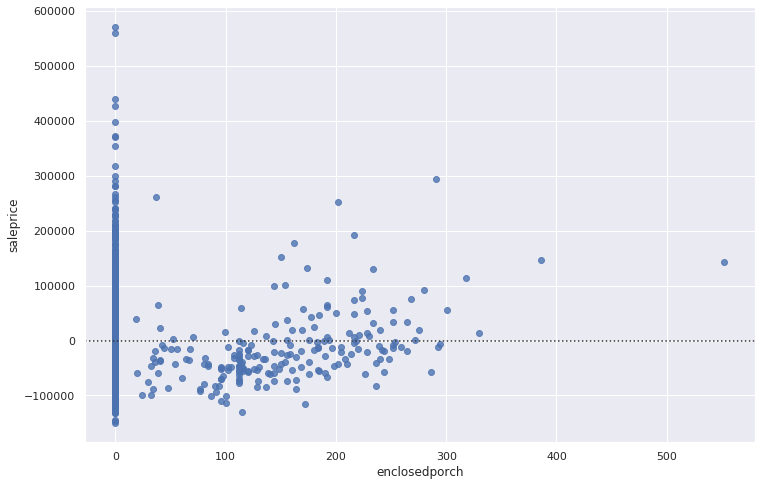

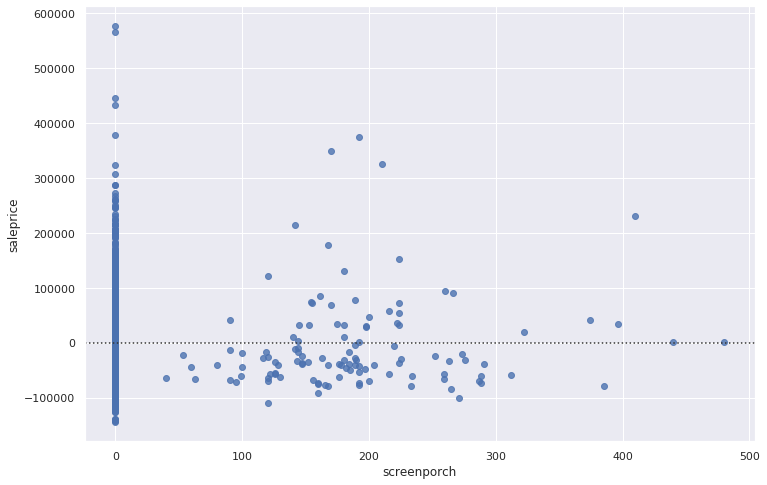

In [0]:
for column in corr_w_target[corr_w_target>0.1].index:
    plt.figure(figsize=(12,8))
    sns.residplot(df[column], df['saleprice'])
    plt.show()

# Feature Engineering

Data must be prepared for modelling.  That said, a preparation strategy will ensure the accomplishment of the following:
* Handling of missing data (nulls)
* Extracting new features from existing data
* Addressing outliers and Normalizing Data
* Handling categorical data
* Selecting the features to build the model





## Handling nulls

In [0]:
# Identify the nulls
nulls = df.isnull().sum()
print(f'{len(nulls[nulls>0])} columns with null values:')
print(nulls[nulls>0])

19 columns with null values:
lotfrontage      259
alley           1369
masvnrtype         8
masvnrarea         8
bsmtqual          37
bsmtcond          37
bsmtexposure      38
bsmtfintype1      37
bsmtfintype2      38
electrical         1
fireplacequ      690
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
garagecond        81
poolqc          1453
fence           1179
miscfeature     1406
dtype: int64


The majority of missing data are 'object' types.  Investigation into the data shows that, in many case, a continuous measurement has a categorical counterpart.  For example, the continuous variable 'garagearea' is related to the features 'garagetype, 'garageyrblt', 'garagefinish', 'garagequal', and 'garagecond'.  The 81 missing values for these correspond to 81 instances of zero garage area.  In other words, the house has no garage.  This example is not unique within this data.  Corresponding "explanations" of missing data are quickly found for 'poolqc', 'fence', 'miscfeature', and the majority of the basement features.  This insight is beneficial to ensuring data loss is kept to a minimum.

In [0]:
# Drop nulls in categoricals without corresponding data to explain loss
drop_cols = ['electrical', 'bsmtfintype2', 'bsmtexposure']

df.dropna(subset=drop_cols, inplace=True)

In [0]:
# Selected columns to replace null with string: 'None'
replace_none = ['alley', 'masvnrtype', 'fireplacequ', 'garagetype', 
                'garagefinish', 'garagecond', 'poolqc', 'fence', 'miscfeature']

for col in replace_none:
    df[col].replace(np.nan, 'None', inplace=True)


In [0]:
# Perform imputation for numeric nulls
numerics_nulls = ['lotfrontage', 'masvnrarea', 'garageyrblt']

for numeric in numerics_nulls:
    if numeric == 'garageyrblt':
        df[numeric] = df[numeric].fillna(df[numeric].mode()[0])
    else:
        df[numeric] = df.groupby('neighborhood')[numeric].transform(lambda x: x.fillna(x.median()))

##Exatract new features

Now that nulls have been addressed, it's time to take a closer look of features most highly correlated with the target.  Some features contain time elements (i.e. year built, year remodled, etc).  While time elements are not have specific enough to treat as chronological time series, useful data may be extracted.

Additionally, several features have heavily imbalanced data.  While distributions of numerical data may be transformed to more approximately normal distributions, imbalanced categorical data will need to be simplified.  

In [0]:
# Subset the data by the features most highly correlated with target.
subset_columns = list(corr_w_target[corr_w_target>0.1].index)+ ['yrsold', 
                                                                'mosold', 
                                                                'saleprice']

df2 = df[subset_columns].copy()

In [0]:
# While year doesn't provide specific time series data, some features may
# still be extracted.
df2['home_age'] = [2010-x for x in df2['yearbuilt']]
df2['garage_age'] = [2010 - x for x in df2['garageyrblt']]
df2['remodel_age'] = [2010 - x for x in df2['yearremodadd']]

# Convert heavily imbalanced data to more balanced binary classes.
df2['1+_halfbath'] = [1 if x >= 1 else 0 for x in df2['halfbath']]
df2['2+_fullbath'] = [0 if x <= 1 else 1 for x in df2['fullbath']]
df2['1+_bsmtfullbath'] = [0 if x < 1 else 1 for x in df2['bsmtfullbath']]
 
# Drop columns that will not be used.
df2 = df2.drop(columns=['yearbuilt', 'garageyrblt', 'yearremodadd', 'halfbath',
                        'fullbath', 'bsmtfullbath'],axis=1)

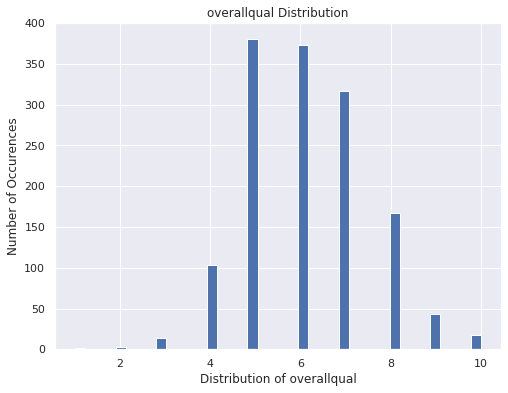

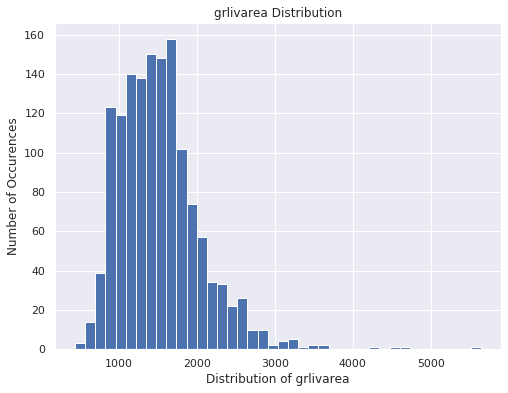

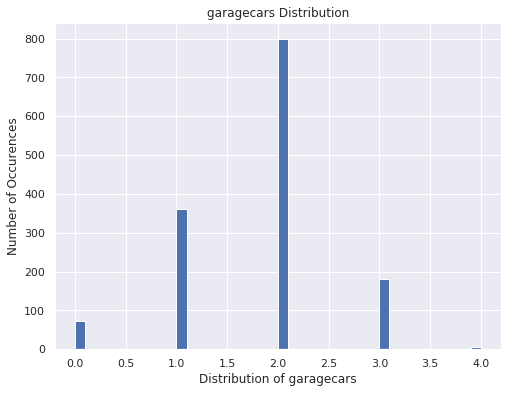

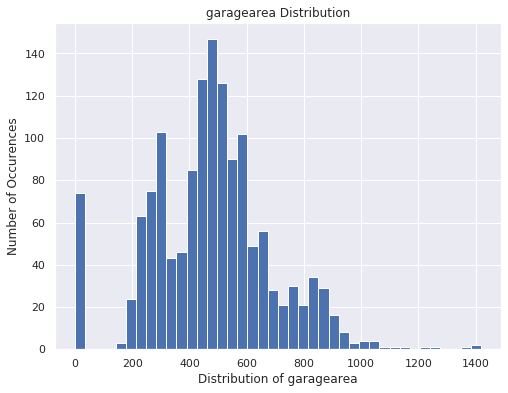

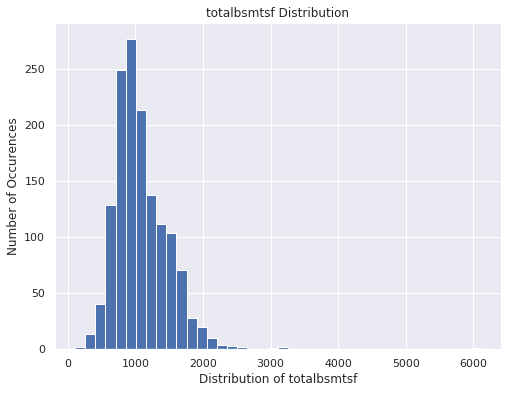

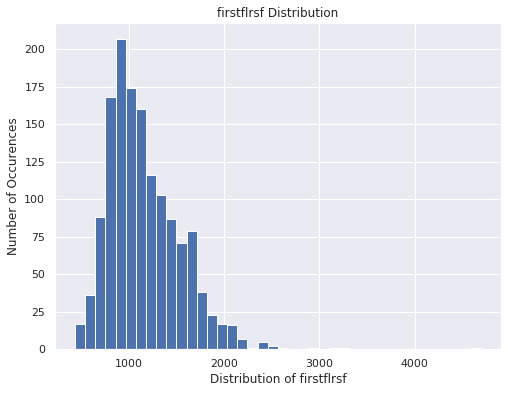

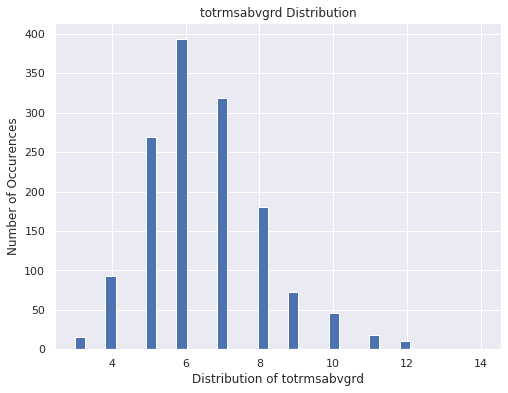

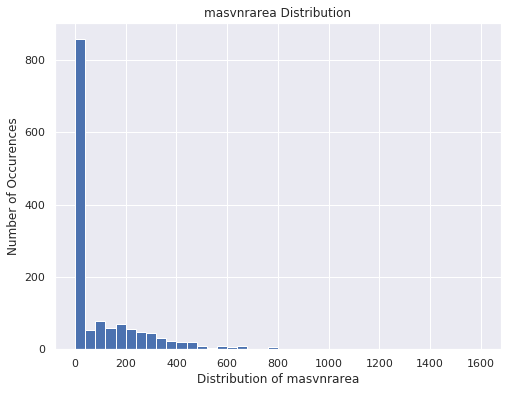

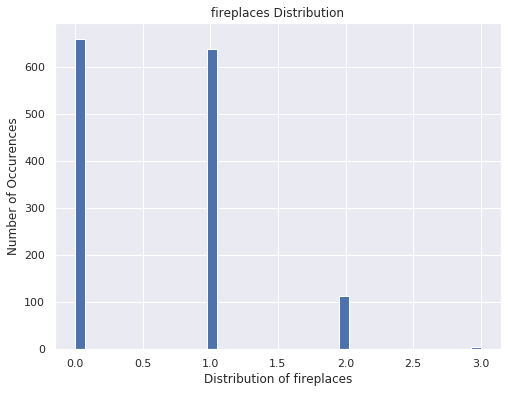

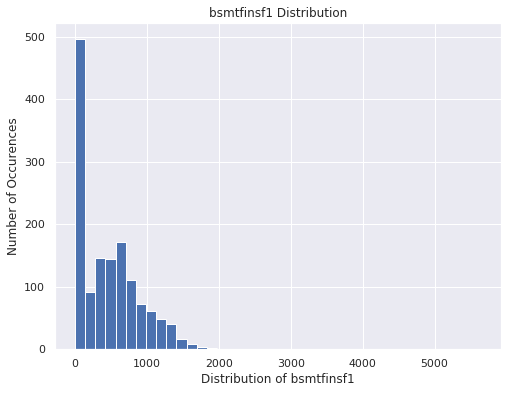

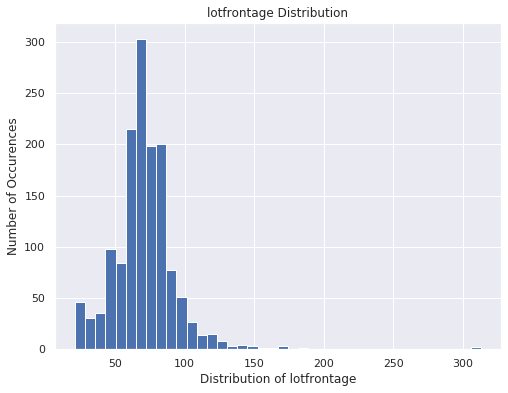

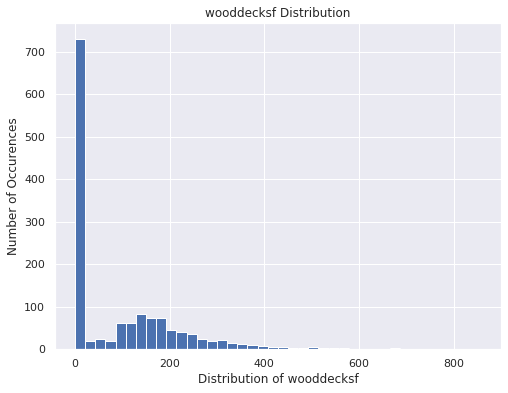

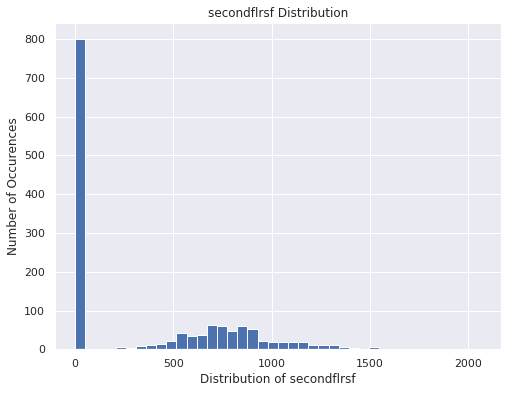

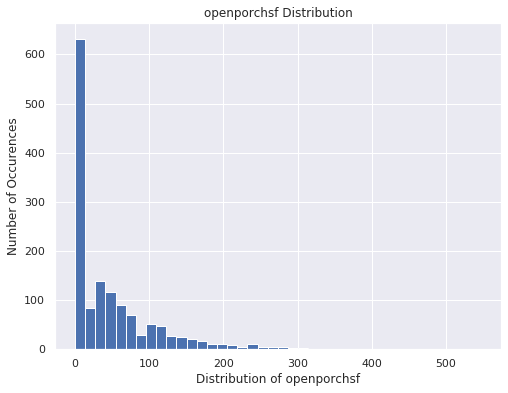

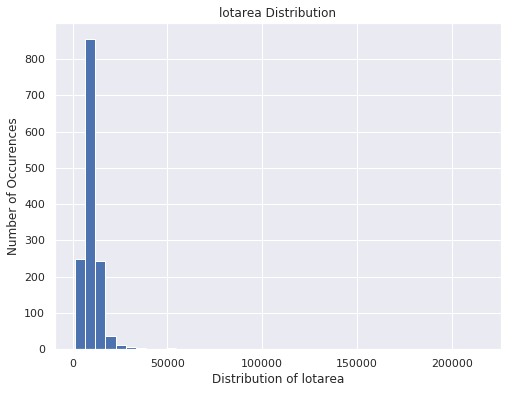

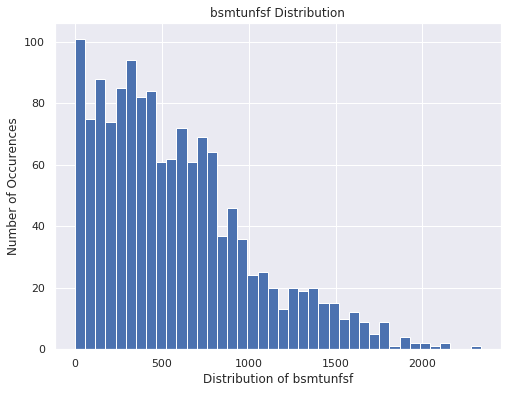

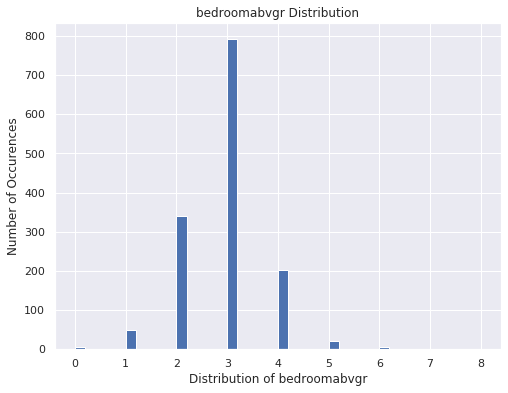

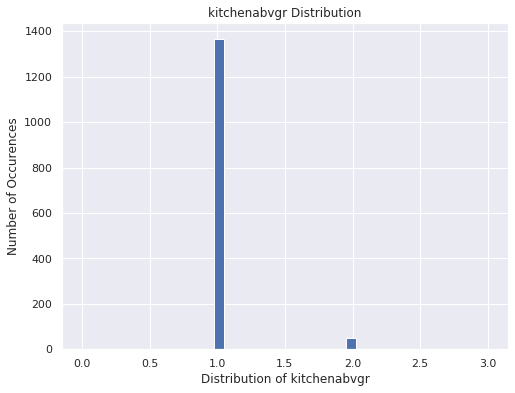

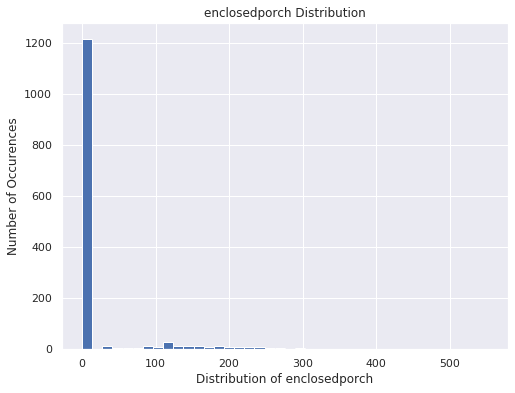

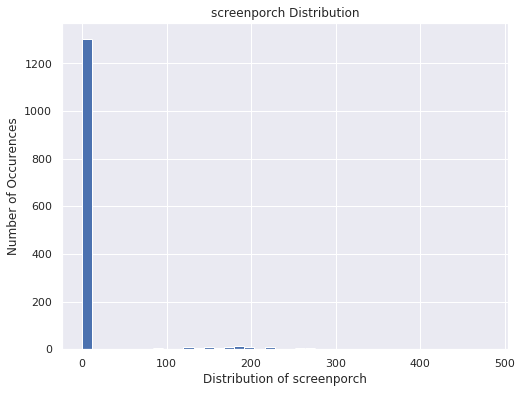

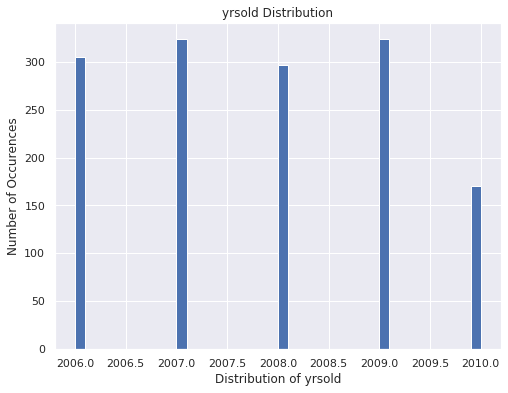

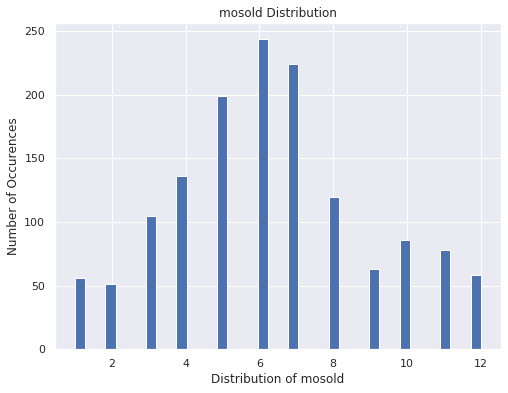

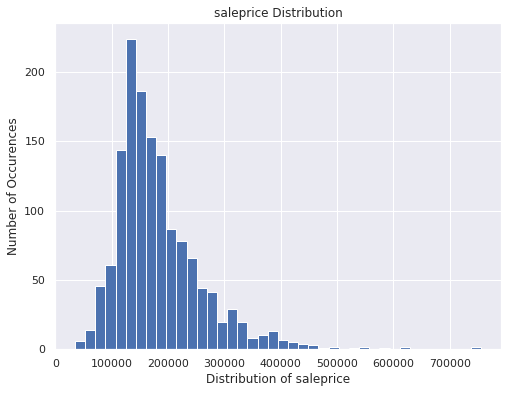

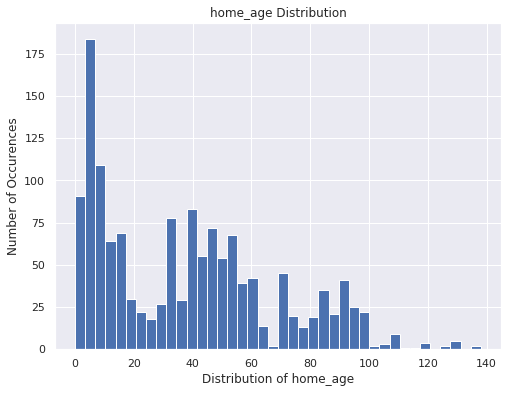

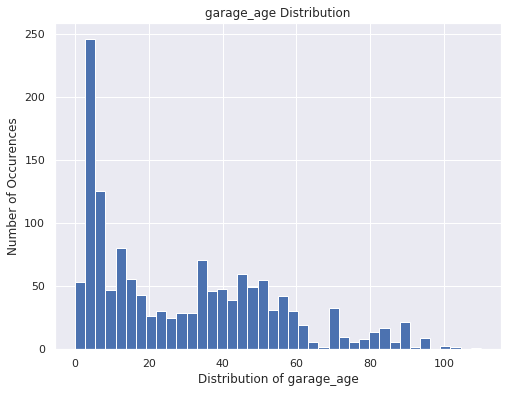

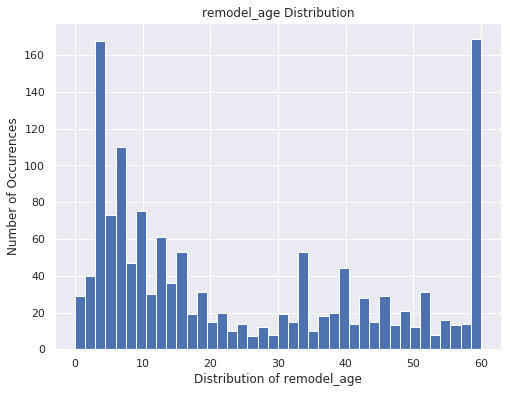

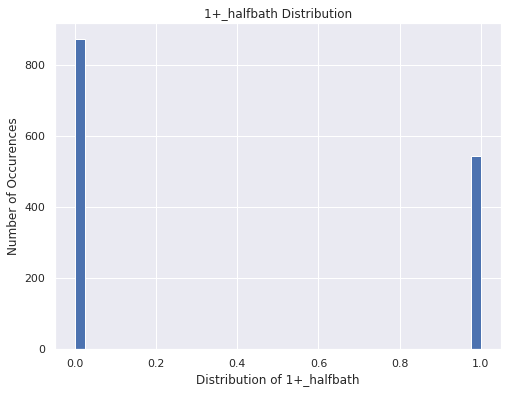

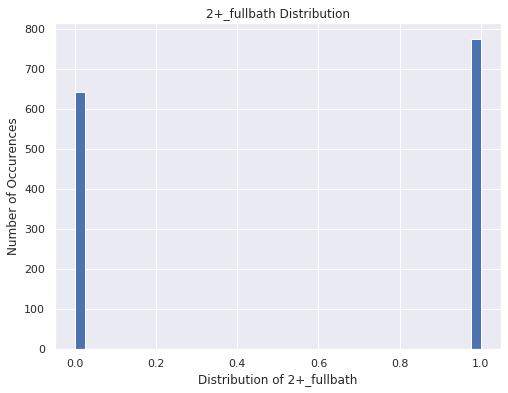

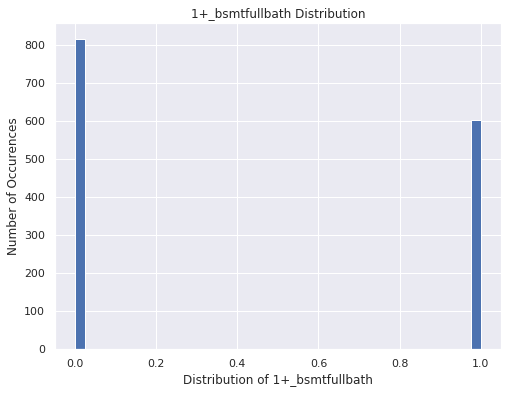

In [0]:
# Plot to visualize distributions of each potential feature
for col in df2.columns:
    plt.figure(figsize=(8,6))
    plt.hist(df2[col], bins=40)
    plt.xlabel(f'Distribution of {col}')
    plt.ylabel('Number of Occurences')
    plt.title(f'{col} Distribution')
    plt.show()

## Transforming Data

Observing the plots, the distributions of features contain imbalances and are non-normally distributed.  While transformation methods (log of data, winsorization, scaling) my not result in ideal approximations of normal distribution, useablity of the data will be enhanced.  

In [0]:
# Initialize dictionary for features and their respective transformations.
feature_transforms = {'overallqual':df2['overallqual'].astype('category').cat.as_ordered(), 
                      'grlivarea':np.log1p(np.sqrt(df2['grlivarea'])),
                      'garagecars':df2['garagecars'].astype('category').cat.as_ordered(), 
                      'garagearea':np.log1p(winsorize(df2['garagearea'], (0.06, 0.0))), 
                      'totalbsmtsf':winsorize(np.log1p((df2['totalbsmtsf'])),(0.005,0.005)), 
                      'firstflrsf':np.log1p(df2['firstflrsf']),
                      '2+_fullbath':df2['2+_fullbath'],
                      'totrmsabvgrd':df2['totrmsabvgrd'].astype('category').cat.as_ordered(),
                      'home_age':df2['home_age'].astype('category').cat.as_ordered(),
                      'remodel_age':df2['remodel_age'].astype('category').cat.as_ordered(),
                      'garage_age':df2['garage_age'].astype('category').cat.as_ordered(),
                      'masvnrarea':normalize(df2['screenporch'].values.reshape(-1,1)),
                      'fireplaces':df2['fireplaces'].astype('category').cat.as_ordered(),
                      'bsmtfinsf1':np.log1p(df2['bsmtfinsf1']),
                      'lotfrontage':np.log1p(df2['lotfrontage']),
                      'wooddecksf':np.sqrt(df2['wooddecksf']),
                      'secondflrsf':np.log1p(df2['secondflrsf']),
                      'openporchsf':np.log1p(df2['openporchsf']),
                      '1+_halfbath':df2['1+_halfbath'],
                      'lotarea':np.log1p(winsorize(df2['lotarea'],(0,0.025))),
                      'bsmtfullbath':df2['1+_bsmtfullbath'],
                      'bsmtunfsf':np.log1p(df2['bsmtunfsf']),
                      'bedroomabvgr':df2['bedroomabvgr'],
                      'kitchenabvgr':df2['kitchenabvgr'],
                      'enclosedporch':normalize(df2['enclosedporch'].values.reshape(-1,1)),
                      'screenporch':normalize(df2['screenporch'].values.reshape(-1,1)),
                      'saleprice':np.log1p(df2['saleprice']),
                      '1+_bsmtfullbath':df2['1+_bsmtfullbath'],
                      'mosold':df2['mosold'],
                      'yrsold':df2['yrsold']}

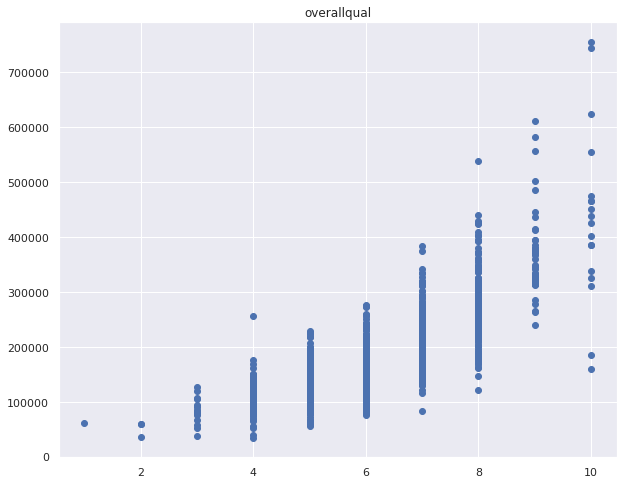

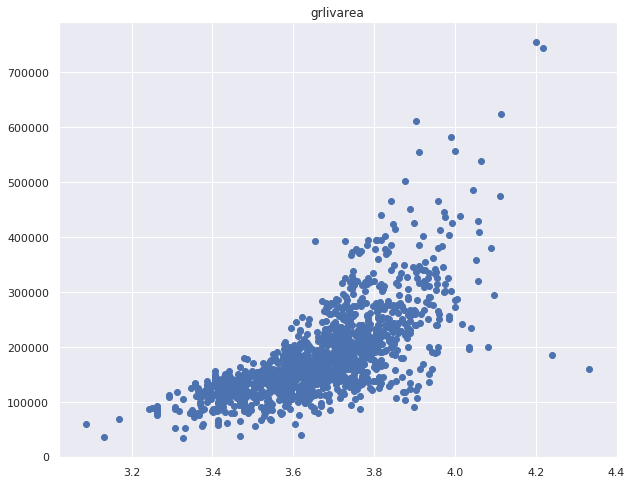

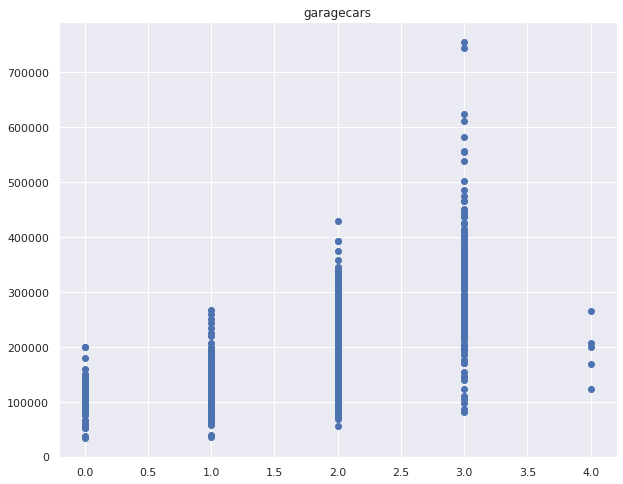

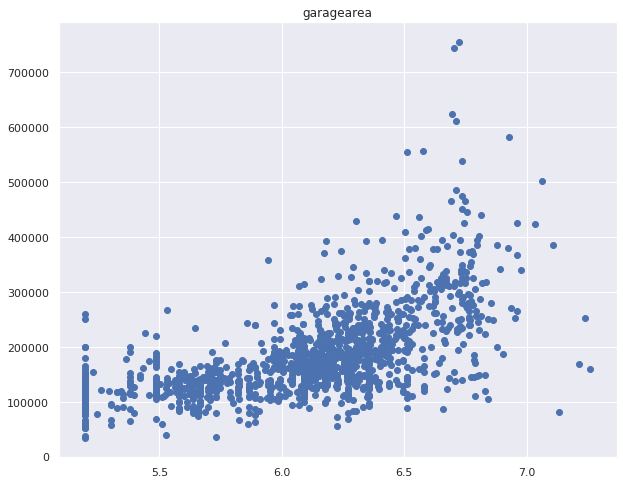

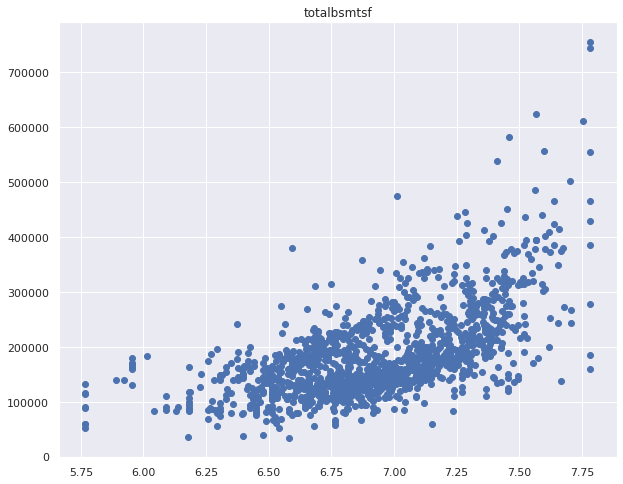

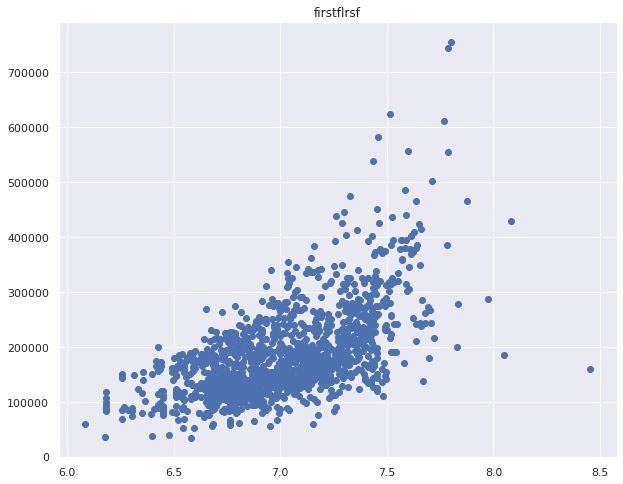

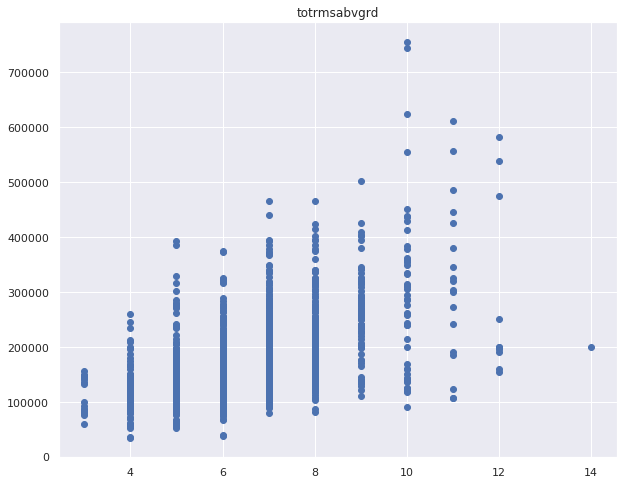

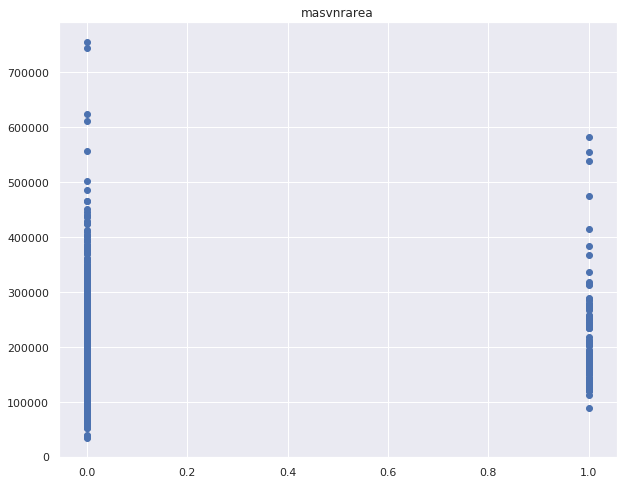

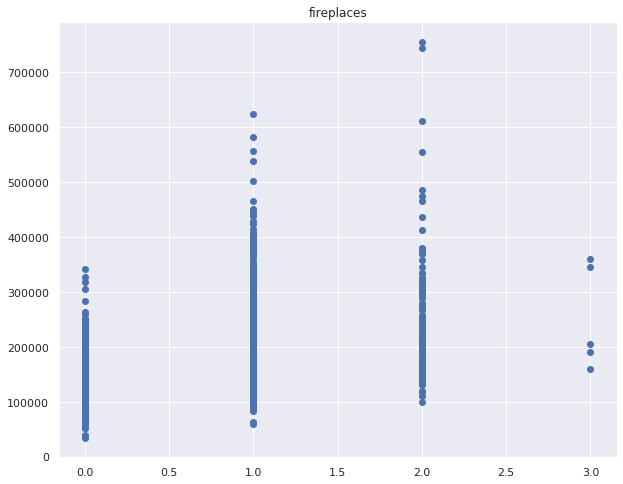

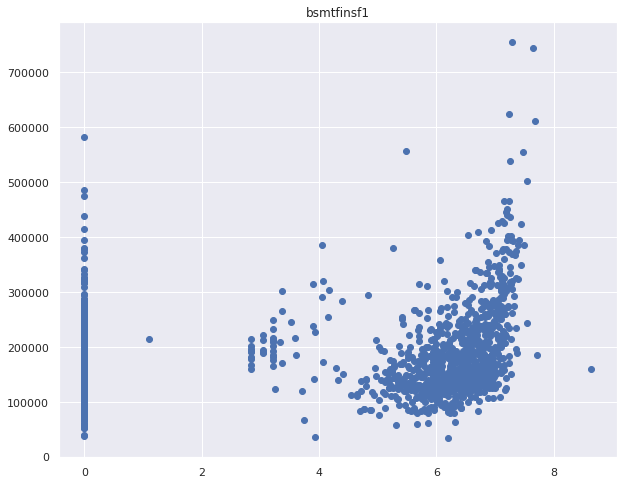

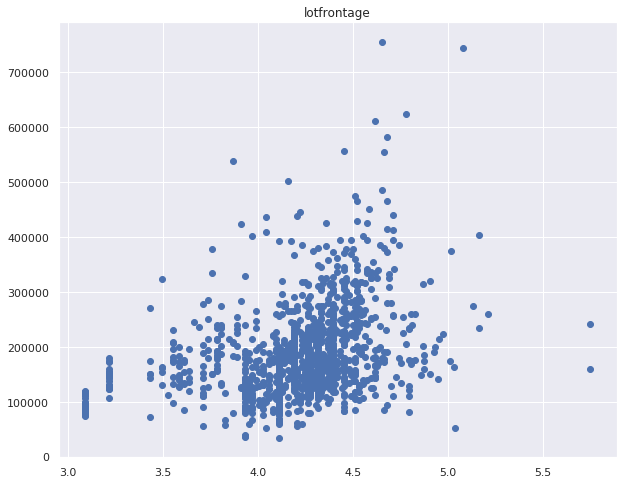

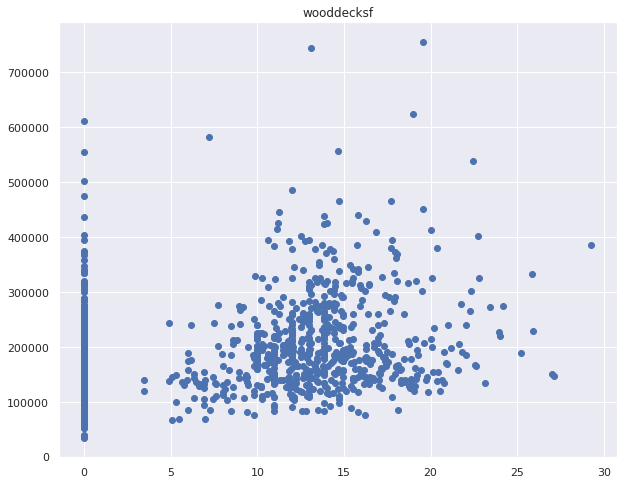

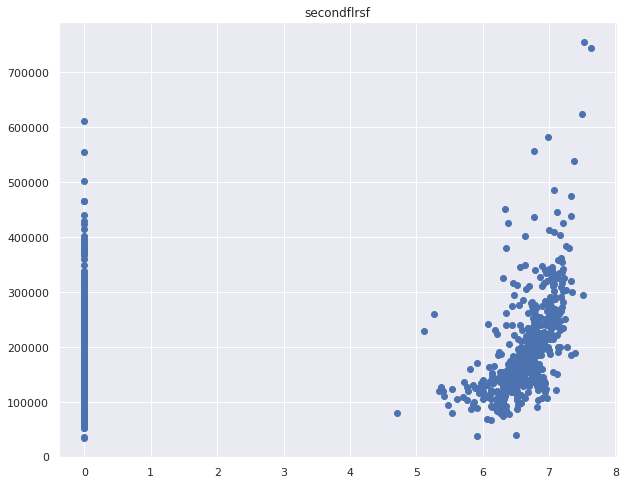

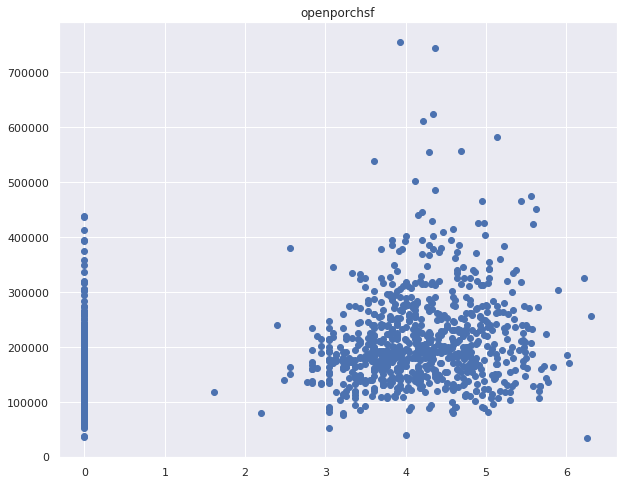

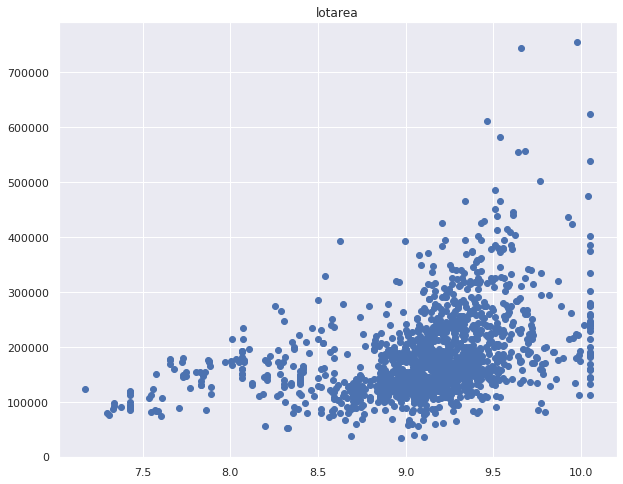

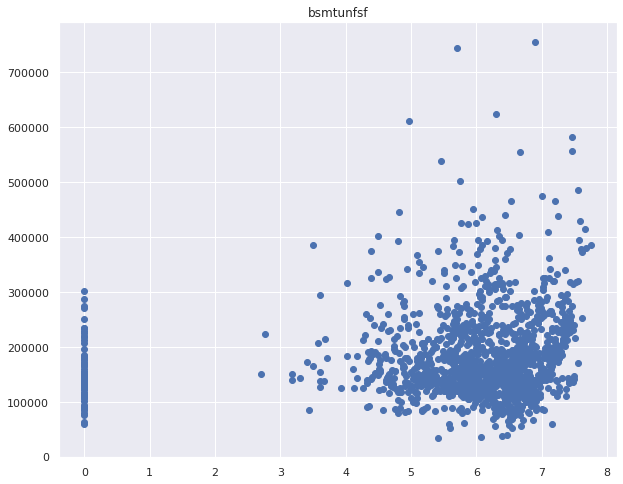

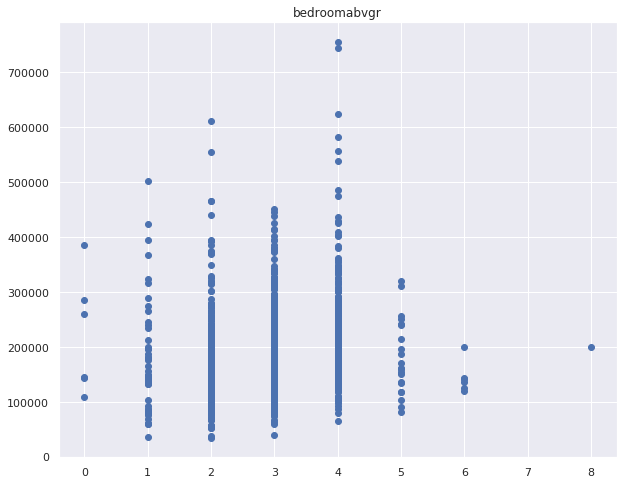

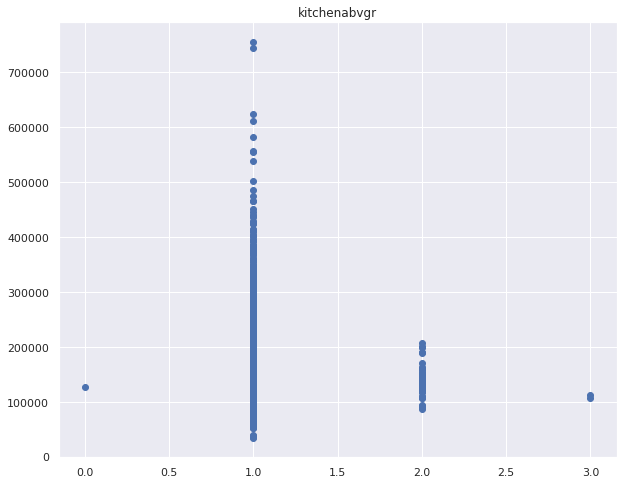

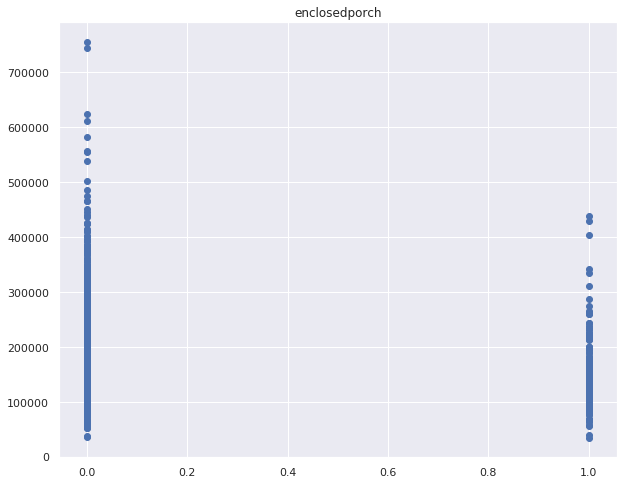

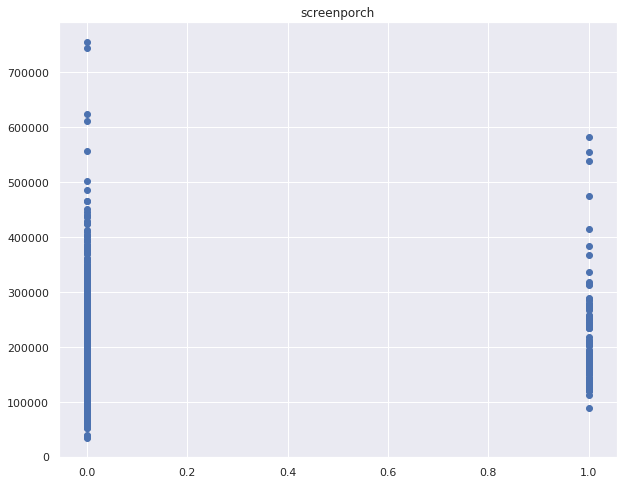

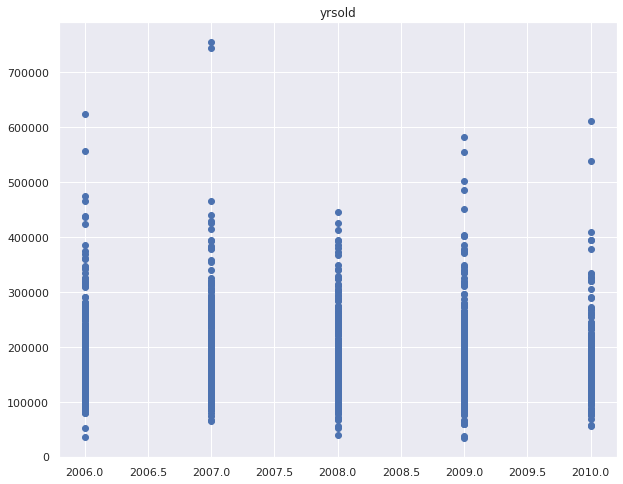

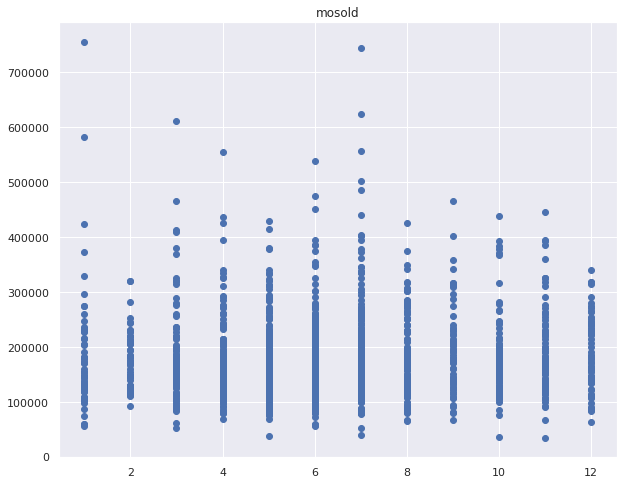

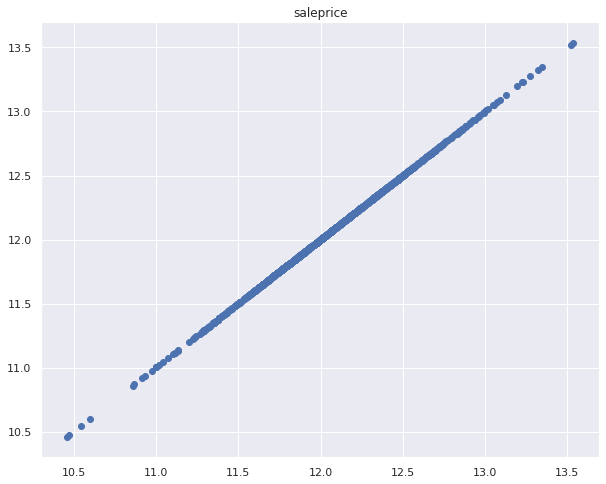

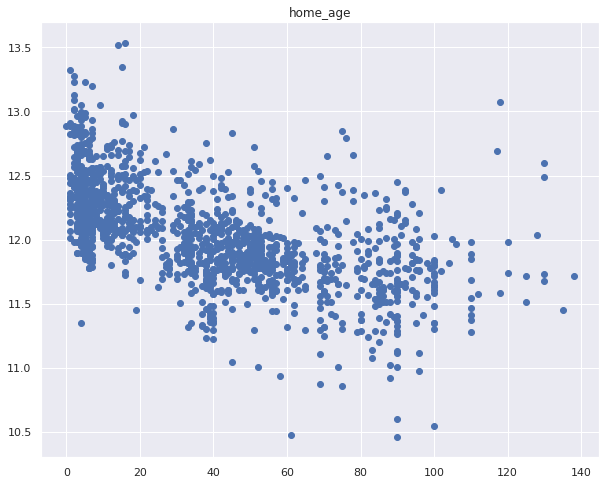

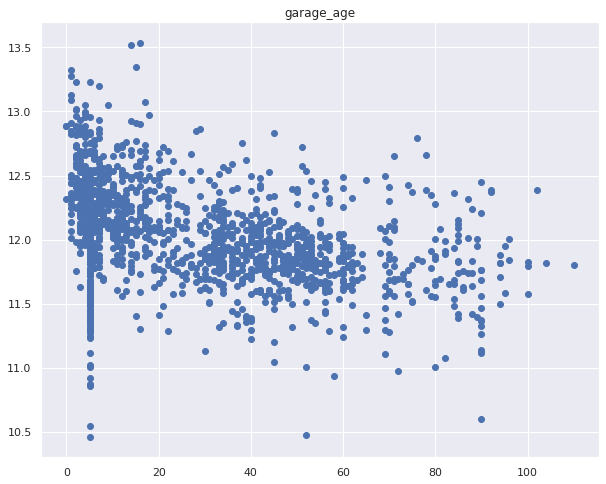

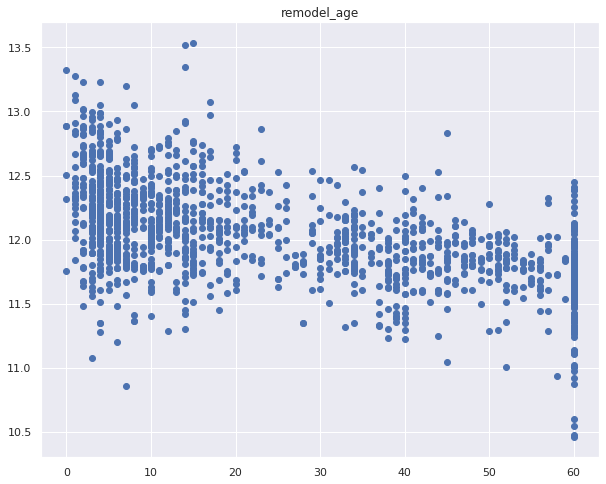

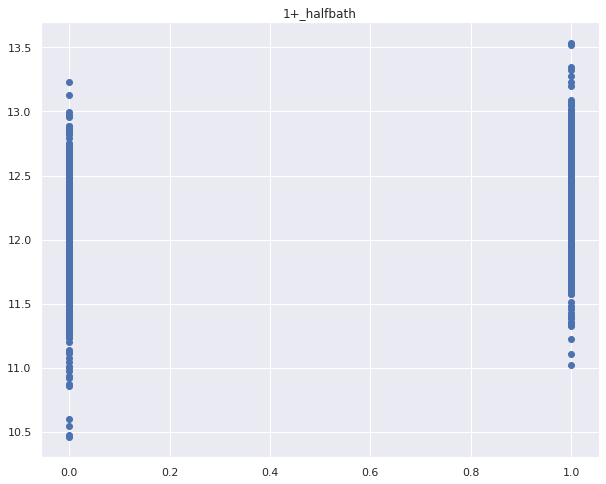

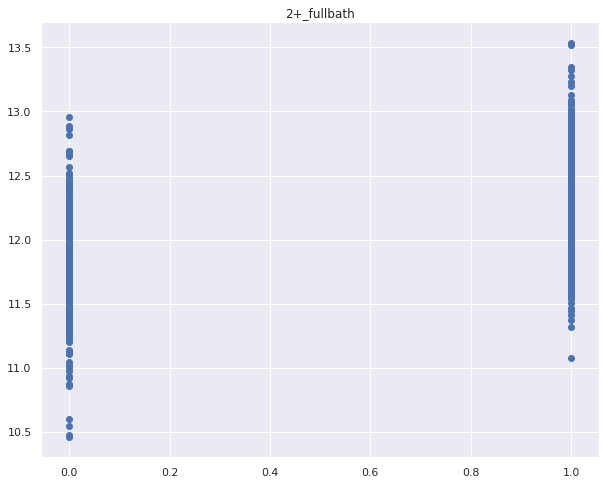

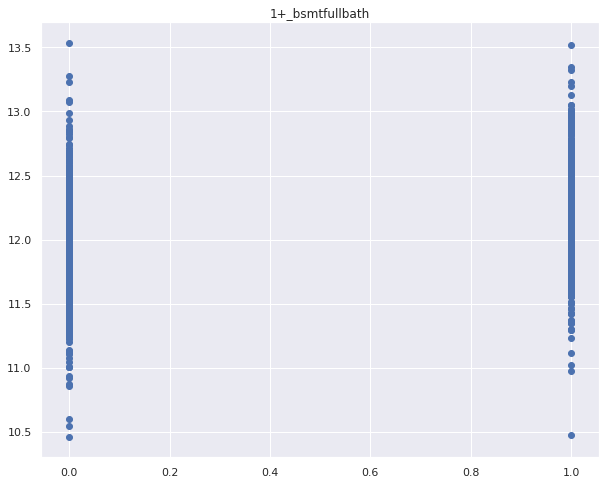

In [0]:
# Plot feature relationships with target data
for column in df2.columns:
    df2[column] = feature_transforms.get(column)
    plt.figure(figsize=(10,8))
    plt.title(column)
    plt.scatter(df2[column], df2['saleprice'],)
    plt.show()

## Feature Selection

Given the cleaner dataset, feature selection can be more directly considered.  However, before features are ultimately decided upon, multicolinearity should be considered.  Given the impact of multicollinearity on reliability of the models that will be used, care must be taken to ensure features are not too correlated with one another.  

Text(0.5, 1, 'Correlation of potential features')

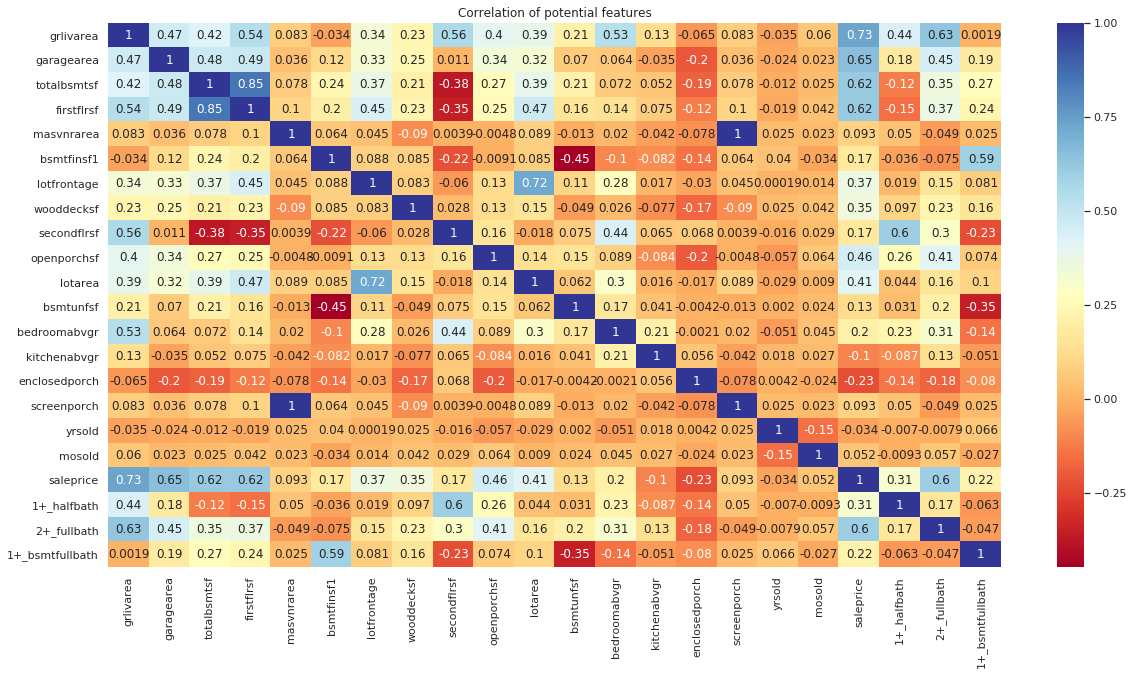

In [0]:
# View Feature correlation
plt.figure(figsize=(20,10))
ax = sns.heatmap(df2.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

Given the correlation observed in the features, feature selction is somewhat difficult.  As seen earlier, redundancy exists in the data, hence the correlation.  By appearances, multicollinearity is going to be difficult to avoid, therefore, some of the highly collinear features will be explored to determine if handling with PCA will be useful.

In [0]:
scaler = StandardScaler()

P = df2[['grlivarea', 'garagearea', 'totalbsmtsf', 'firstflrsf']]
P2 = df2[['screenporch', 'masvnrarea']]

P = scaler.fit_transform(P)
P2 = scaler.fit_transform(P2)

pca = PCA(n_components=1)
pca2 = PCA(n_components=1)

df2['pca1'] = pca.fit_transform(P)
df2['pca2'] = pca2.fit_transform(P2)

In [0]:
df2[['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'firstflrsf', 
     'masvnrarea', 'screenporch', 'pca1', 'pca2']].corr()

saleprice  grlivarea  garagearea  ...  screenporch      pca1      pca2
saleprice     1.000000   0.730655    0.650639  ...     0.092962  0.795945  0.092962
grlivarea     0.730655   1.000000    0.468965  ...     0.082774  0.729592  0.082774
garagearea    0.650639   0.468965    1.000000  ...     0.036152  0.729552  0.036152
totalbsmtsf   0.615925   0.419435    0.478631  ...     0.077702  0.869147  0.077702
firstflrsf    0.617772   0.542207    0.485388  ...     0.100543  0.907034  0.100543
masvnrarea    0.092962   0.082774    0.036152  ...     1.000000  0.092896  1.000000
screenporch   0.092962   0.082774    0.036152  ...     1.000000  0.092896  1.000000
pca1          0.795945   0.729592    0.729552  ...     0.092896  1.000000  0.092896
pca2          0.092962   0.082774    0.036152  ...     1.000000  0.092896  1.000000

[9 rows x 9 columns]

In [0]:
# Drop columns summarized with PCA variables
df2 = df2.drop(columns=['grlivarea', 'garagearea', 'totalbsmtsf', 'firstflrsf', 
                        'masvnrarea', 'screenporch'], axis=1)


The variance within the groupings of features are better explained through PCA with the PCA variable having either a higher or equal correlation with the target.  In both cases, the PCA variable will be used.

In [0]:
# Separate features and target
X = df2.drop(columns=['saleprice', 'yrsold', 'mosold'], axis=1)
y = df2['saleprice']


# Model Preparation

Linear Regression models, while similar in concept, have inherent differences in their predictive algorithms.  Given the small size and dimensionality of this experiment, Regression models such as Lasso and ElasticNet might not be ideal fits.  Regardless, OLS, Ridge, Lasso, and ElasticNet models will be tuned and evaluated to determine which is best suited.  While several scoring computations will be performed, the deciding metric will be the Root Mean Squared Error.

## First Attempt


### Model

In [0]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,
                                                    random_state=42)
# Set X constants for train and test splits
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Parameters for Ridge
tn_params = [{'alpha':[1, 5, 10, 50, 100, 1000, 10000]}]
tn_params2 = [{'alpha':[1, 5, 10, 50, 100, 1000, 10000], 
               'l1_ratio':[0.3, 0.4, 0.5]}]

# Initialize and fit models
model_ols = sm.OLS(list(y_train), X_train.astype(int)).fit()
model_rdg = GridSearchCV(Ridge(), param_grid=tn_params, cv=5)
model_lss = GridSearchCV(Lasso(), param_grid=tn_params, cv=5)
model_elt = GridSearchCV(ElasticNet(), param_grid=tn_params2, cv=5)

model_rdg.fit(X_train, y_train)
model_lss.fit(X_train, y_train)
model_elt.fit(X_train, y_train)
model_ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     308.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:20:43   Log-Likelihood:                 551.89
No. Observations:                1136   AIC:                            -1058.
Df Residuals:                    1113   BIC:                            -942.0
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.8425      0.100    108.678      0.000      10.647      11.038
overallqual         0.0947      0.006     16.752      0.000       0.084       0.106
garagecars          0.0318      0.009      3.381      0.001       0.013       0.050
totrmsabvgrd        0.0263      0.005      4.789      0.000       0.016       0.037
fireplaces          0.0469      0.008      5.627      0.000       0.031       0.063
bsmtfinsf1          0.0130      0.002      5.675      0.000       0.009       0.018
lotfrontage         0.0126      0.014      0.898      0.369      -0.015       0.040
wooddecksf          0.0025      0.001      3.611      0.000       0.001       0.004
secondflrsf         0.0094      0.003      3.581      0.000       0.004       0.014
openporchsf         0.0053      0.003      1.921      0.055      -0.000       0.011
lotarea             0.0437      0.010      4.356      0.000       0.024       0.063
bsmtunfsf          -0.0009      0.004     -0.264      0.792      -0.008       0.006
bedroomabvgr       -0.0056      0.008     -0.673      0.501      -0.022       0.011
kitchenabvgr       -0.0894      0.026     -3.500      0.000      -0.140      -0.039
enclosedporch       0.0133      0.015      0.902      0.367      -0.016       0.042
home_age           -0.0014      0.000     -4.858      0.000      -0.002      -0.001
garage_age          0.0006      0.000      2.262      0.024    8.41e-05       0.001
remodel_age        -0.0027      0.000     -8.887      0.000      -0.003      -0.002
1+_halfbath         0.0204      0.013      1.533      0.126      -0.006       0.047
2+_fullbath         0.0281      0.015      1.914      0.056      -0.001       0.057
1+_bsmtfullbath     0.0305      0.012      2.529      0.012       0.007       0.054
pca1                0.0828      0.007     12.066      0.000       0.069       0.096
pca2                0.0140      0.004      3.192      0.001       0.005       0.023
==============================================================================
Omnibus:                      557.327   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10973.569
Skew:                          -1.789   Prob(JB):                         0.00
Kurtosis:                      17.800   Cond. No.                     1.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
print(model_rdg.best_score_)
print(model_rdg.best_estimator_.alpha)

0.8554457670027795
10


In [0]:
print(model_lss.best_score_)
print(model_lss.best_estimator_.alpha)

0.3921048802729967
1


In [0]:
print(model_elt.best_score_)
print(model_elt.best_estimator_.alpha)
print(model_elt.best_estimator_.l1_ratio)

0.46143616964840106
1
0.3


### Model Performance

In [0]:
ols_pred = model_ols.predict(X_test)
rdg_pred = model_rdg.predict(X_test)
lss_pred = model_lss.predict(X_test)
elt_pred = model_elt.predict(X_test)

predictions = {'OLS':ols_pred, 'Ridge':rdg_pred, 'Lasso':lss_pred, 
               'ElasticNet':elt_pred}

for k,v in predictions.items():
    model_scorer(v, y_test, k, ['rmse'])

------- OLS Model Eval. -------
Root Mean Squared Error:  0.14464936716782356
------- Ridge Model Eval. -------
Root Mean Squared Error:  0.13686834091562355
------- Lasso Model Eval. -------
Root Mean Squared Error:  0.2960407135549455
------- ElasticNet Model Eval. -------
Root Mean Squared Error:  0.27878099073630763


The initial OLS model has an R-square of 0.859 (adjusted R-square: 0.856).  Based upon this metric, the OLS model performs better than the other models.  The Ridge regression model is the second best performer with a 0.855 R-square.

The Lasso and ElasticNet models did not perform well.  With fewer degrees of freedom present in the data, these models, as indicated by their respective performance, are not likely appropriate for this experiment. 

While the OLS model appears to perform better than the Ridge model, according to the R-squared score, the evaluative metric is Root Mean Squared Error (RMSE).  According to the Root Mean Squared Error, the performance gap between the OLS and Ridge regression model is smaller.  In fact, the Ridge regression model performs slightly better according to this metric:
* OLS RMSE: 0.1446
* Ride RMSE: 0.1369

This may be an indication of model overfitting.  Looking at the OLS model the several features showing insignificant P >|t| values are likely noise with their respective coefficients adding unnecessary complexity to the model.  Additional data preparation may be possible before tuning and reevaluating a new model.  

Given the initial performance of Lasso and ElasticNet models, they will be excluded from further tuning.  Instead, emphasis will be placed on the OLS and Ridge Regression models moving forward.

## Second Attempt

### Feature adjustments

In [0]:
# Calculate error to test Linear Regression Assumptions
error = [m - n for m,n in zip(y_test, ols_pred)]

In [0]:
# The average error is a small number approaching zero.
np.mean(error)

-0.03222804535150979

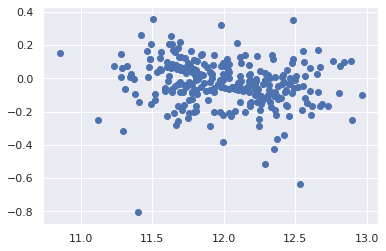

BartlettResult(statistic=239.49557227860035, pvalue=5.0663332766168286e-54) LeveneResult(statistic=242.74358086339248, pvalue=8.346166682296366e-46)


In [0]:
# Assumption:  Homoscedasticity
plt.scatter(ols_pred, error)
plt.show()


bart_stats = bartlett(ols_pred, error) 
lev_stats = levene(ols_pred, error)

print(bart_stats, lev_stats)

In [0]:
X = add_constant(X)

pd.Series([variance_inflation_factor(X.astype(float).values, i) for i in range(X.astype(float).shape[1])], index=X.columns)

const              748.714137
overallqual          2.951565
garagecars           2.459179
totrmsabvgrd         4.161088
fireplaces           1.519586
bsmtfinsf1           1.909827
lotfrontage          2.230483
wooddecksf           1.220844
secondflrsf          3.548147
openporchsf          1.441759
lotarea              2.456580
bsmtunfsf            1.484122
bedroomabvgr         2.247038
kitchenabvgr         1.321383
enclosedporch        1.359980
home_age             4.095971
garage_age           2.389607
remodel_age          1.958963
1+_halfbath          2.153561
2+_fullbath          2.758714
1+_bsmtfullbath      1.741322
pca1                 5.296893
pca2                 1.105337
dtype: float64

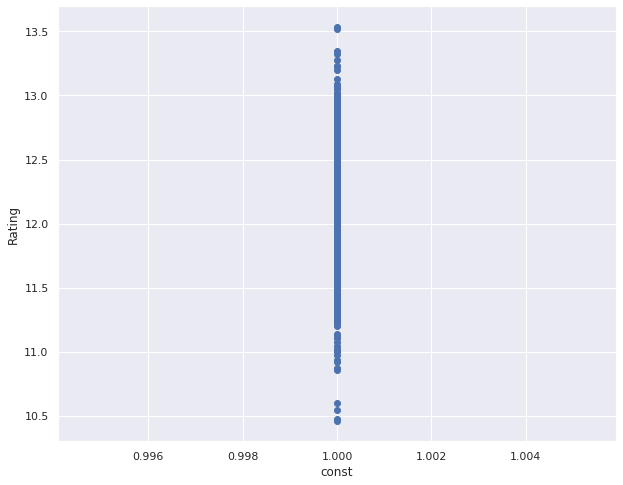

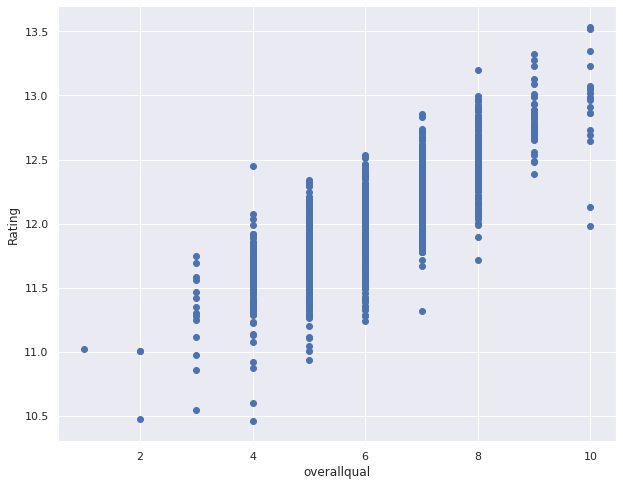

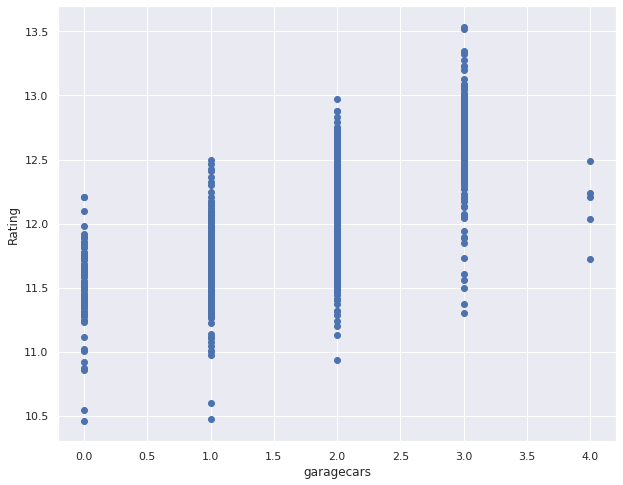

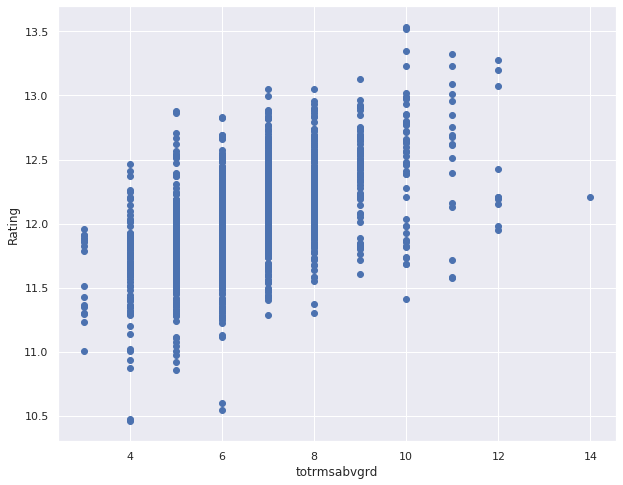

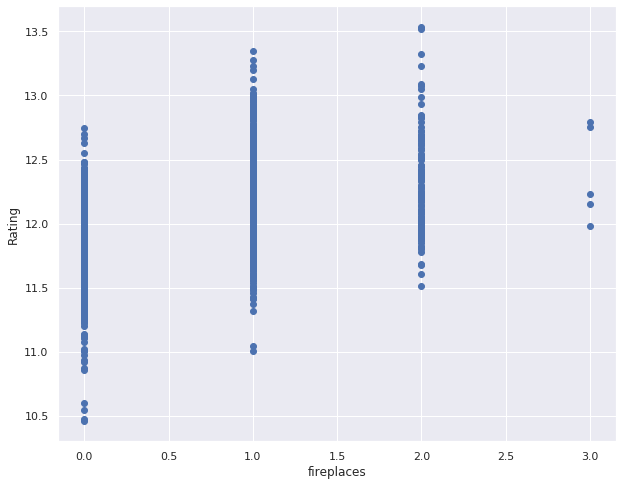

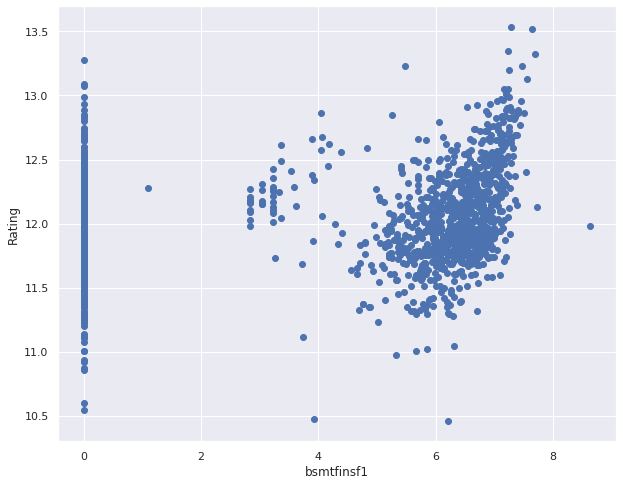

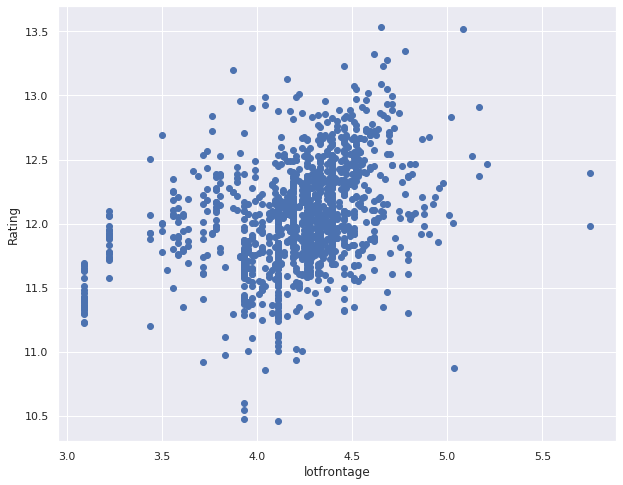

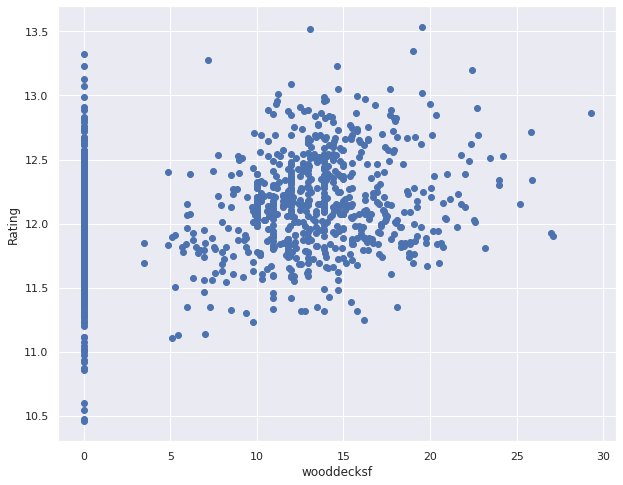

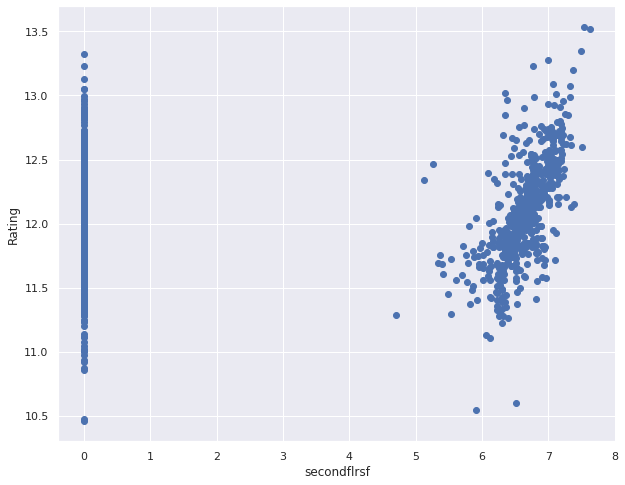

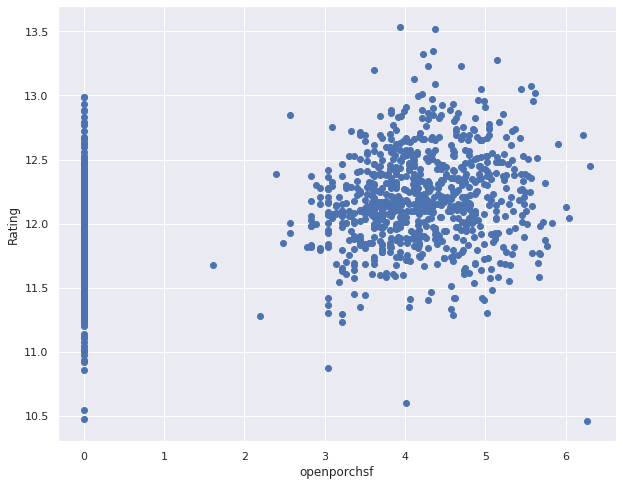

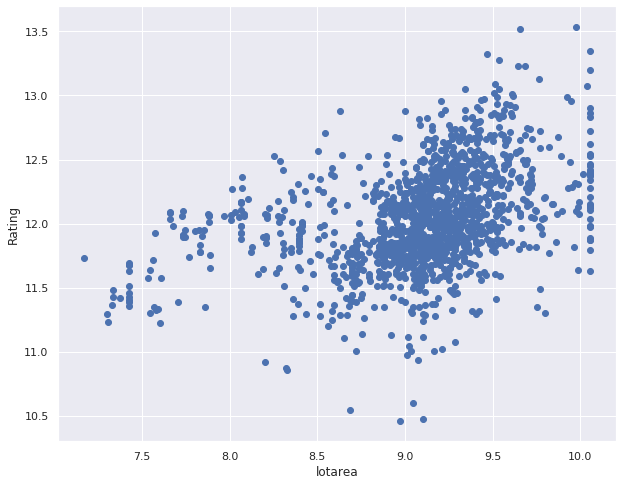

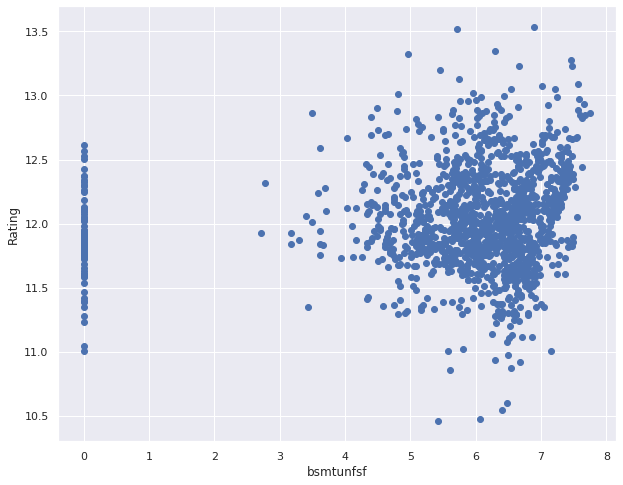

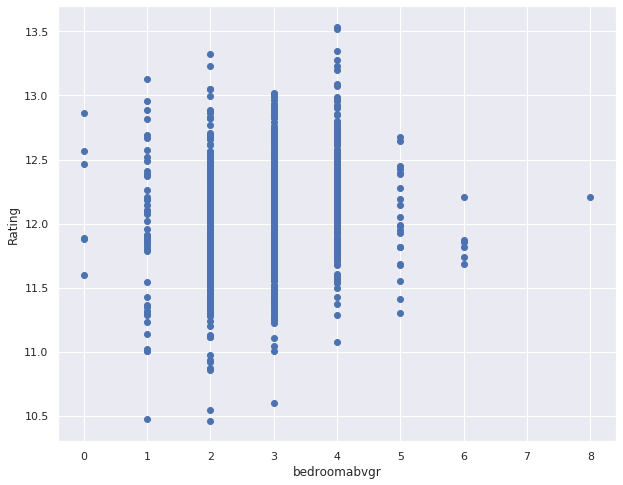

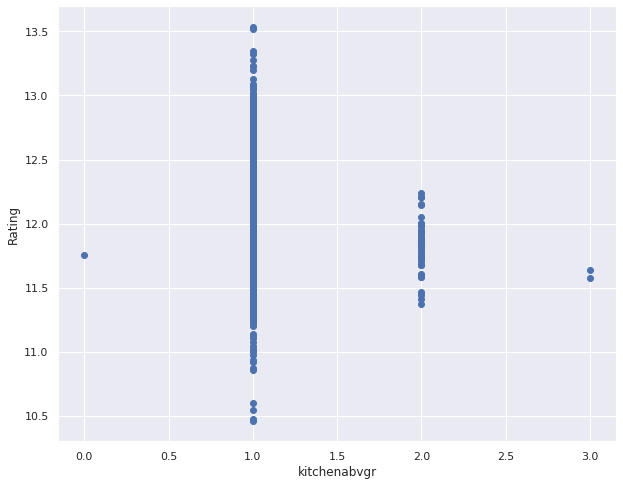

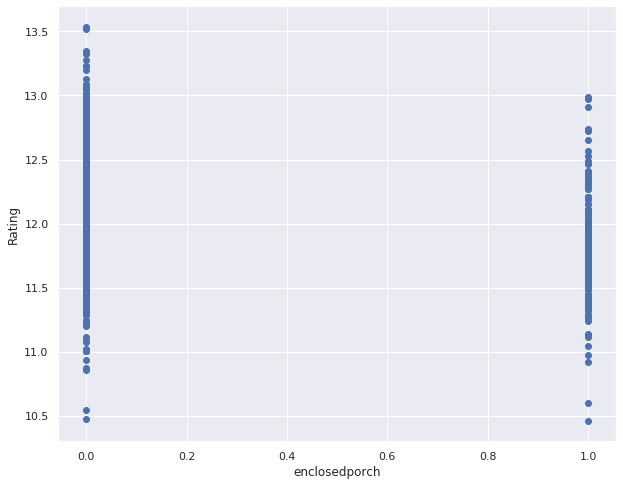

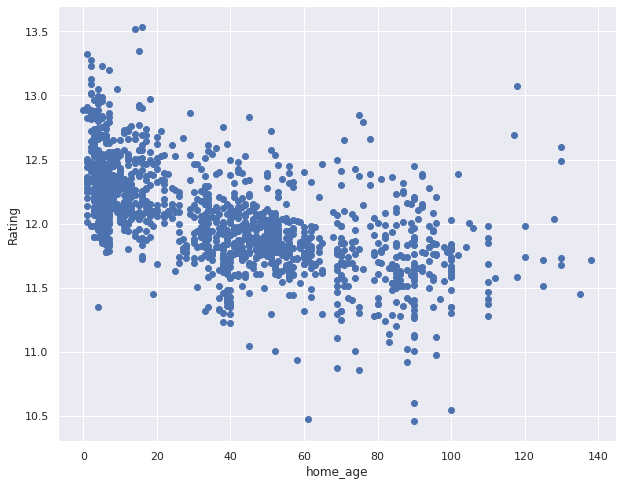

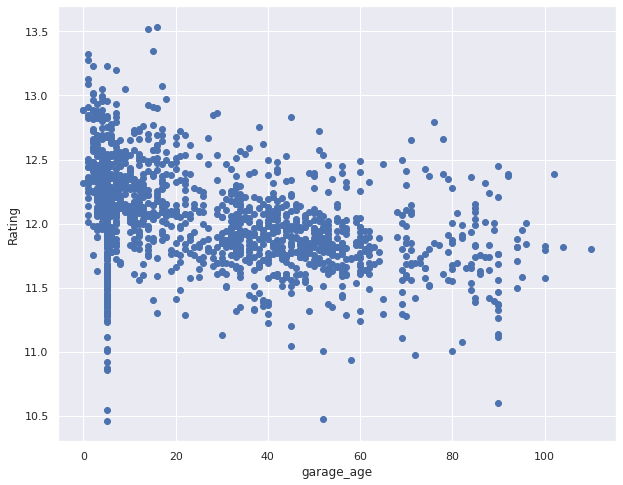

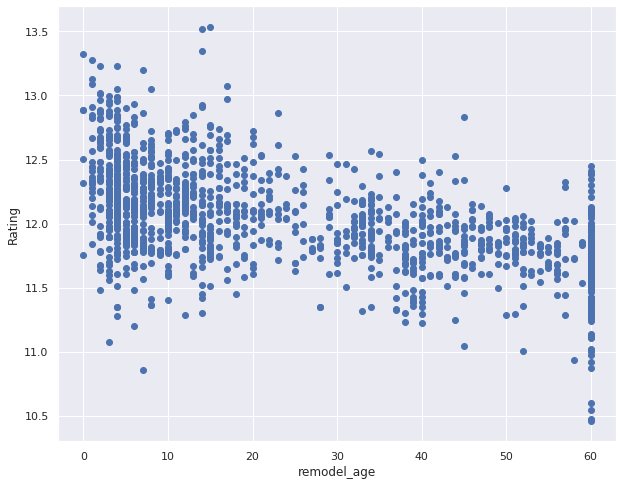

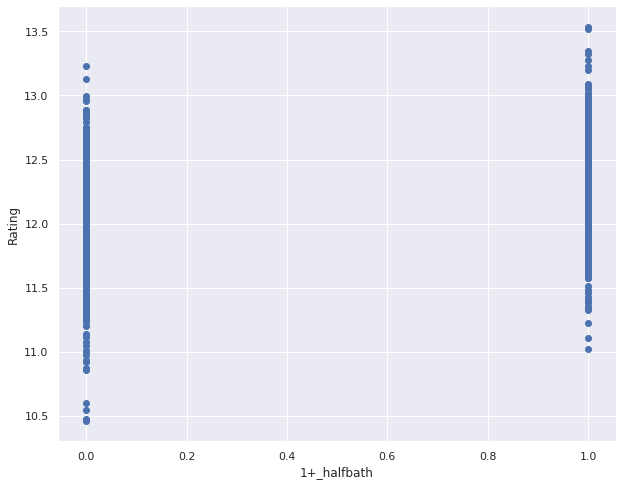

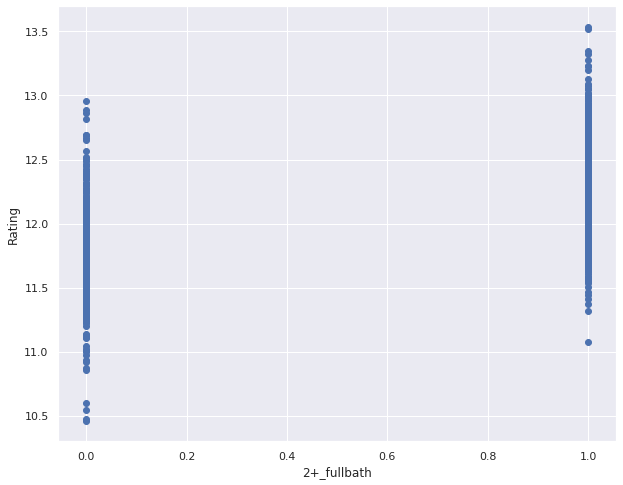

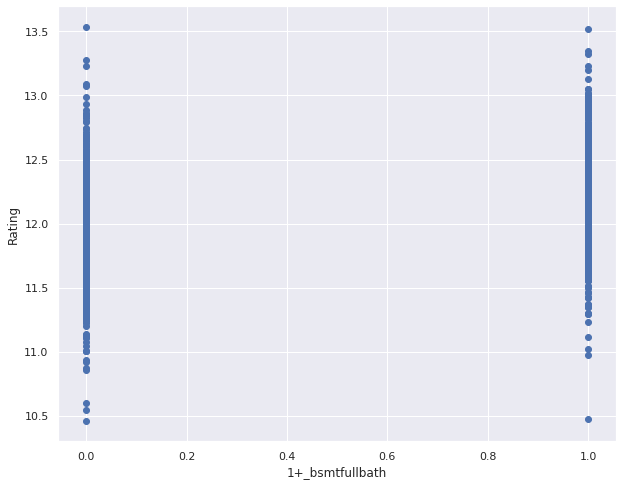

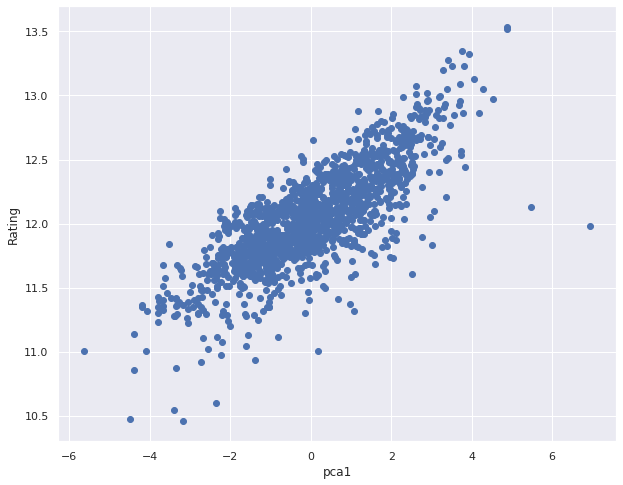

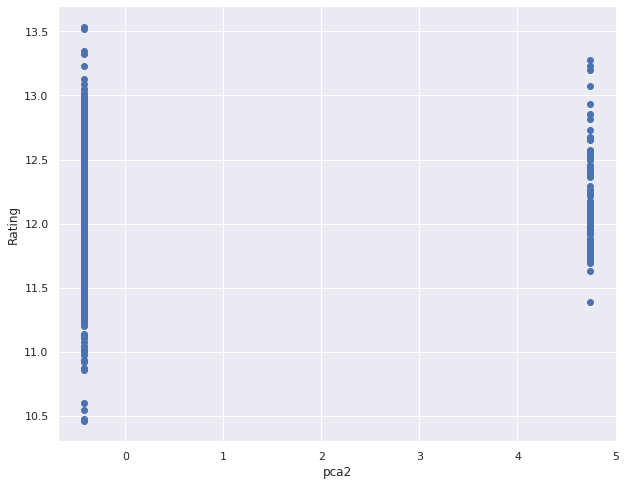

In [0]:
# answer below:
for x in X_test.columns:
  plt.figure(figsize=(10,8))
  plt.scatter(X[x], y)
  plt.xlabel(f'{x}')
  plt.ylabel('Rating')
  plt.show()

The assumption of Homescedasticity seems to fail.  On the other hand, despite the pca1 feature appearing suspicious, the VIF calculations help demonstrate the assumption of the absence of multicollinearity is reasonable.  Observing the plots of the features, however, does show that noise exists.  


In [0]:
# Copy feature data for exploration.
X2 = X.copy()

In [0]:
# Take additional step to handle outlier data
P3 = df2[['1+_halfbath', '2+_fullbath', '1+_bsmtfullbath']]
P3 = scaler.fit_transform(P3)
pca3 = PCA(n_components=1)

df2['pca3'] = pca3.fit_transform(P3)

In [0]:
df2[['saleprice', 'pca3', '1+_halfbath', '2+_fullbath', '1+_bsmtfullbath']].corr()

saleprice      pca3  1+_halfbath  2+_fullbath  1+_bsmtfullbath
saleprice         1.000000  0.473700     0.314958     0.599536         0.219496
pca3              0.473700  1.000000     0.727938     0.710776        -0.402485
1+_halfbath       0.314958  0.727938     1.000000     0.166293        -0.062792
2+_fullbath       0.599536  0.710776     0.166293     1.000000        -0.047297
1+_bsmtfullbath   0.219496 -0.402485    -0.062792    -0.047297         1.000000

Correlation with target is better demonstrated with '2+_fullbath' feature.  

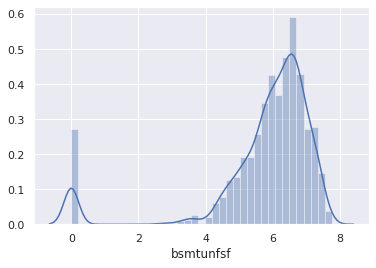

In [0]:
sns.distplot(X['bsmtunfsf'])

In [0]:
# Address outlier ing 'bsmtunfsf' 
X2['bsmtunfsf'] = np.sqrt(winsorize(X['bsmtunfsf'], (0.075, 0.00)))

# Address noisy features
X2['lotfrontage_area_ratio'] = X2['lotfrontage']/X2['lotarea']
X2['pca3'] = df2['pca3']

X2 = X2.drop(columns=['1+_halfbath', '1+_bsmtfullbath', 'enclosedporch'], axis=1)

### Model

In [0]:
# Re-run and evaluate OLS and Ridge Models
# Split data into train and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.20,
                                                    random_state=42)

# Set X constants for train and test splits
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

# Parameters for Ridge
tn_params = [{'alpha':[5, 6, 7, 8, 9, 10]}]

# Initialize and fit models
model_ols = sm.OLS(y_train, X2_train.astype(float)).fit()
model_rdg = GridSearchCV(Ridge(), param_grid=tn_params, cv=5)

model_rdg.fit(X2_train, y_train)

print(model_rdg.best_score_)
print(model_rdg.best_estimator_.alpha)
model_ols.summary()

0.8550535067421124
10


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     349.0
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:20:56   Log-Likelihood:                 589.72
No. Observations:                1136   AIC:                            -1135.
Df Residuals:                    1114   BIC:                            -1025.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6.5848      1.033      6.377      0.000       4.559       8.611
overallqual                0.0940      0.006     17.021      0.000       0.083       0.105
garagecars                 0.0198      0.009      2.117      0.034       0.001       0.038
totrmsabvgrd               0.0198      0.005      3.632      0.000       0.009       0.030
fireplaces                 0.0317      0.008      3.877      0.000       0.016       0.048
bsmtfinsf1                 0.0115      0.002      5.173      0.000       0.007       0.016
lotfrontage               -1.0591      0.253     -4.186      0.000      -1.556      -0.563
wooddecksf                 0.0018      0.001      2.740      0.006       0.001       0.003
secondflrsf                0.0145      0.002      6.080      0.000       0.010       0.019
openporchsf                0.0030      0.002      1.251      0.211      -0.002       0.008
lotarea                    0.5629      0.114      4.957      0.000       0.340       0.786
bsmtunfsf                 -0.0716      0.036     -2.005      0.045      -0.142      -0.002
bedroomabvgr              -0.0069      0.008     -0.873      0.383      -0.023       0.009
kitchenabvgr              -0.1027      0.025     -4.156      0.000      -0.151      -0.054
home_age                  -0.0017      0.000     -6.465      0.000      -0.002      -0.001
garage_age                 0.0006      0.000      2.287      0.022    8.81e-05       0.001
remodel_age               -0.0026      0.000     -8.879      0.000      -0.003      -0.002
2+_fullbath                0.0019      0.016      0.122      0.903      -0.029       0.032
pca1                       0.0830      0.006     12.988      0.000       0.070       0.096
pca2                       0.0089      0.003      2.745      0.006       0.003       0.015
lotfrontage_area_ratio     9.3677      2.290      4.091      0.000       4.875      13.861
pca3                       0.0037      0.008      0.471      0.638      -0.012       0.019
==============================================================================
Omnibus:                      543.969   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8723.185
Skew:                          -1.797   Prob(JB):                         0.00
Kurtosis:                      16.091   Cond. No.                     3.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Performance

In [0]:
ols_pred = model_ols.predict(X2_test)
rdg_pred = model_rdg.predict(X2_test)

predictions = {'OLS':ols_pred, 'Ridge':rdg_pred}

for k,v in predictions.items():
    model_scorer(v, y_test, k, ['rmse'])



------- OLS Model Eval. -------
Root Mean Squared Error:  0.1408000855509691
------- Ridge Model Eval. -------
Root Mean Squared Error:  0.13748384534591304


The initial OLS model has an R-square of 0.868 (adjusted R-square: 0.866) would suggest the model has improved.  Based upon this metric, the Ridge regression model corrected slightly from a 0.8554 to a 0.8551 R-square.

While the OLS model appears to perform better than the Ridge model, according to the R-squared score, the change in performance is minimal.  Additionally, according to the RMSE, the performance gap between the OLS and Ridge regression model is growing:
* OLS RMSE: 0.1408
* Ride RMSE: 0.1375

The drop in performance indicates a correction from overfitting perviously, however, it should be noted the changes are minimal.  Also of note, models exhibit noise that needs to be addressed.

## Third Attempt

### Feature adjustments

In [0]:
X2 = X2.drop(columns=['2+_fullbath', 'bedroomabvgr'])

In [0]:
from sklearn.preprocessing import StandardScaler, normalize
scaler = StandardScaler()

X2['openporchsf'] = scaler.fit_transform(X2['openporchsf'].values.reshape(-1,1))
X2['openporchsf'] = normalize(X2['openporchsf'].values.reshape(-1,1))


### Model

In [0]:
# Re-run and evaluate OLS and Ridge Models
# Split data into train and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.20,
                                                    random_state=42)

# Set X constants for train and test splits
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

# Parameters for Ridge
tn_params = [{'alpha':[1, 2, 3, 4, 5]}]

# Initialize and fit models
model_ols = sm.OLS(y_train, X2_train.astype(float)).fit()
model_rdg = GridSearchCV(Ridge(), param_grid=tn_params, cv=5)

model_rdg.fit(X2_train, y_train)

print(model_rdg.best_score_)
print(model_rdg.best_estimator_.alpha)
model_ols.summary()

0.8557983524356362
5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     386.0
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:20:56   Log-Likelihood:                 589.14
No. Observations:                1136   AIC:                            -1138.
Df Residuals:                    1116   BIC:                            -1038.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6.6306      1.033      6.418      0.000       4.604       8.658
overallqual                0.0949      0.005     17.442      0.000       0.084       0.106
garagecars                 0.0204      0.009      2.202      0.028       0.002       0.039
totrmsabvgrd               0.0174      0.005      3.648      0.000       0.008       0.027
fireplaces                 0.0327      0.008      4.039      0.000       0.017       0.049
bsmtfinsf1                 0.0114      0.002      5.151      0.000       0.007       0.016
lotfrontage               -1.0519      0.253     -4.155      0.000      -1.549      -0.555
wooddecksf                 0.0018      0.001      2.729      0.006       0.001       0.003
secondflrsf                0.0143      0.002      6.088      0.000       0.010       0.019
openporchsf                0.0060      0.005      1.150      0.250      -0.004       0.016
lotarea                    0.5585      0.114      4.915      0.000       0.336       0.781
bsmtunfsf                 -0.0738      0.036     -2.073      0.038      -0.144      -0.004
kitchenabvgr              -0.1012      0.024     -4.179      0.000      -0.149      -0.054
home_age                  -0.0017      0.000     -6.419      0.000      -0.002      -0.001
garage_age                 0.0006      0.000      2.222      0.026    6.99e-05       0.001
remodel_age               -0.0027      0.000     -9.065      0.000      -0.003      -0.002
pca1                       0.0832      0.006     13.321      0.000       0.071       0.095
pca2                       0.0088      0.003      2.731      0.006       0.002       0.015
lotfrontage_area_ratio     9.2916      2.291      4.056      0.000       4.796      13.787
pca3                       0.0037      0.007      0.538      0.591      -0.010       0.017
==============================================================================
Omnibus:                      531.310   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8200.298
Skew:                          -1.753   Prob(JB):                         0.00
Kurtosis:                      15.687   Cond. No.                     3.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Performance

In [0]:
ols_pred = model_ols.predict(X2_test)
rdg_pred = model_rdg.predict(X2_test)

predictions = {'OLS':ols_pred, 'Ridge':rdg_pred}

for k,v in predictions.items():
    model_scorer(v, y_test, k, ['rmse'])


------- OLS Model Eval. -------
Root Mean Squared Error:  0.14094404281934292
------- Ridge Model Eval. -------
Root Mean Squared Error:  0.13780974576821195


The OLS model has held a consistent R-square of 0.868 (adjusted R-square: 0.866) while the Ridge regression model showed a slight improvement with a 0.8558 R-square.

The RMSE performance has slightly decreased indicating correction of overfitting:
* OLS RMSE: 0.1409
* Ride RMSE: 0.1378

That changes have been very small may indicated this pair of models are reaching the limits of achieving practical improvements.  Another iteration will be performed to reduce the noise still seen in the OLS and determine if further improvements may be achieved.

##Fourth Attempt

### Feature Adjustments

In [0]:
# Drop noisy data
X2 = X2.drop(columns=['openporchsf', 'pca3'], axis=1)

### Model

In [0]:
# Re-run and evaluate OLS and Ridge Models
# Split data into train and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.20,
                                                    random_state=42)

# Set X constants for train and test splits
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

# Parameters for Ridge
tn_params = [{'alpha':[3, 3.5, 4, 4.5, 5, 5.5]}]

# Initialize and fit models
model_ols = sm.OLS(y_train, X2_train.astype(float)).fit()
model_rdg = GridSearchCV(Ridge(), param_grid=tn_params, cv=5)

model_rdg.fit(X2_train, y_train)

print(model_rdg.best_score_)
print(model_rdg.best_estimator_.alpha)
model_ols.summary()

0.8564401187250676
5.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     431.4
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:20:57   Log-Likelihood:                 588.27
No. Observations:                1136   AIC:                            -1141.
Df Residuals:                    1118   BIC:                            -1050.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6.5789      1.032      6.375      0.000       4.554       8.604
overallqual                0.0950      0.005     17.476      0.000       0.084       0.106
garagecars                 0.0203      0.009      2.190      0.029       0.002       0.038
totrmsabvgrd               0.0176      0.005      3.698      0.000       0.008       0.027
fireplaces                 0.0334      0.008      4.142      0.000       0.018       0.049
bsmtfinsf1                 0.0111      0.002      5.082      0.000       0.007       0.015
lotfrontage               -1.0643      0.253     -4.210      0.000      -1.560      -0.568
wooddecksf                 0.0017      0.001      2.648      0.008       0.000       0.003
secondflrsf                0.0154      0.002      7.818      0.000       0.012       0.019
lotarea                    0.5642      0.113      4.973      0.000       0.342       0.787
bsmtunfsf                 -0.0709      0.035     -2.015      0.044      -0.140      -0.002
kitchenabvgr              -0.1030      0.024     -4.272      0.000      -0.150      -0.056
home_age                  -0.0018      0.000     -7.178      0.000      -0.002      -0.001
garage_age                 0.0006      0.000      2.098      0.036    3.63e-05       0.001
remodel_age               -0.0027      0.000     -9.282      0.000      -0.003      -0.002
pca1                       0.0843      0.006     13.631      0.000       0.072       0.096
pca2                       0.0088      0.003      2.719      0.007       0.002       0.015
lotfrontage_area_ratio     9.3972      2.288      4.107      0.000       4.908      13.886
==============================================================================
Omnibus:                      537.483   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8404.917
Skew:                          -1.776   Prob(JB):                         0.00
Kurtosis:                      15.843   Cond. No.                     3.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The adjustments to the 'time_before_upgraded' and 'masvnrarea' improve the model a little more.  R-squared scoring is consistently higher than the OLS model.  Both models return a RMSE below 0.15, however, the Ridge model performs slightly better in this metric.  Additionally, the RMSE difference between the two models in this most recent iteration is larger than previous iterations; indicating the performance of the Ridge model is separating from the OLS model.



In [0]:
ols_pred = model_ols.predict(X2_test)
rdg_pred = model_rdg.predict(X2_test)

predictions = {'OLS':ols_pred, 'Ridge':rdg_pred}

for k,v in predictions.items():
    model_scorer(v, y_test, k, ['rmse'])


------- OLS Model Eval. -------
Root Mean Squared Error:  0.14029840074455524
------- Ridge Model Eval. -------
Root Mean Squared Error:  0.13680638326132954


# Model Implementation

## Final Model

While tuning appears to result in small improvements to both the OLS and Ridge models, futher tuning does not appear provide substantial value gains.  Additionally, the performance differences between the two models have been consistent and allow for the reasonable selection of the Ridge model as the better performer.  

In [0]:
model = Ridge(alpha=5.5)
model.fit(X2_train, y_train)

y_predict = model.predict(X2_test)

model_scorer(y_predict, y_test, 'Ridge Regressor (log)', ['rmse'])
model_scorer(np.expm1(y_predict), np.expm1(y_test), 'Ridge Regressor (dollars)',
             ['rmse'])

------- Ridge Regressor (log) Model Eval. -------
Root Mean Squared Error:  0.13680638326132954
------- Ridge Regressor (dollars) Model Eval. -------
Root Mean Squared Error:  24262.981275620004


## Interpretation

The current Ridge Regression Model demonstrates the ability to predict prices within an approximately $24,263 range.  More specific domain knowledge would be useful in determining the application of the model results, however, some general applications may be:
* Appraisals - as a reference to supply/demand, the value of a property will ultimately be the amount the market will bear.  The model prediction, adjusted by the error, helps gauge the market value.
* Loan value - related to appraisals, loaning institutions often determine the amount they will risk (with a loan) on the value of the property.  This is a factor that relates to sale price and down payment.
* Negotiation strategy - understanding the model prediction, adjusted by the error, may form a baseline understanding of a property's value that can impact how the sale is negotiated:
 * Using the model predition and error, buyers may be able to confidently negotiate a lower price on a property that is priced above the error range.
 * Sellers may use the model to help set pricing with a "cushions" to show flexibility in negotiation while maximizing their return. 

# Considerations

Any implemented model will yield results based on the specific data inputs it has been designed to consider.  However, other external factors may warrant consideration.  For example, consider the following plot.  

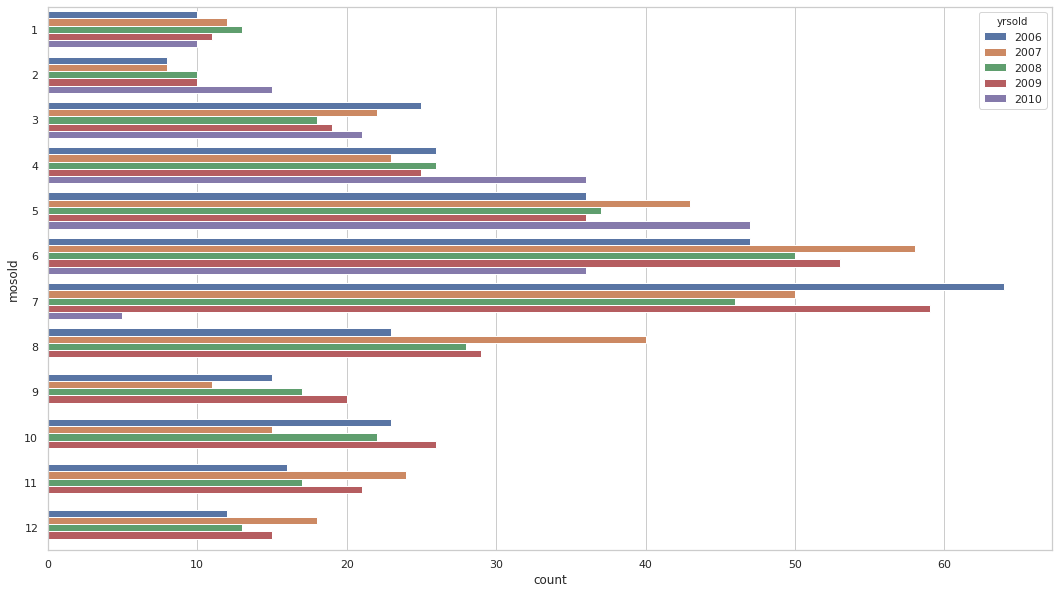

In [0]:
# Plot month of sales within data
sns.set(style="whitegrid")
plt.figure(figsize=(18,10))
sns.countplot(y="mosold", hue="yrsold", data=df)
plt.show()

One primary insight from the plot is the peaking of home sales in the summer months.  These peaks may be explained by weather data that is not present in the model.  

A deeper look, however, demonstrates economic impacts of house sales.  Years 2008, 2009, and the available data on 2010, while following the same monthly trend, are somewhat erratic and do not show a year-over-year growth trend.  This is explained by the economic downturn, termed "The Great Recession", beginning at some point between 2007 and early 2009.  

This plot, alone, implies the existence of these external factors that could, potentially, improve the model.

Using the 'yrsold' and 'mosold' data contained within the data set, it may be possible to test another model that includes potentially useful external data.  The following implementation is a brief experiment with externally collected data.  External data will include:
* Crime_rate - historical data of Ames, IA crime rates; collected from https://www.macrotrends.net/
* weather - historical weather data of Des Moines Internation Airports station (Des Moines is 30 miles away from Ames, IA); collected from https://www.wunderground.com/
* university enrollment - Ames, IA is home to Iowa State University.  Data includes historical changes in enrollment; collected from https://www.registrar.iastate.edu/

## Load and Explore new data

In [0]:
# Verify observations match features and dataframe
df2.shape, X2.shape

((1420, 26), (1420, 18))

In [0]:

df_crime = pd.read_csv('ames_crime.csv')
df_weather = pd.read_csv('ia_weather.csv')
df_enrollment = pd.read_csv('isu_enrollment.csv')

In [0]:
df_crime.head()

yr_month  year_code  crime_rate
0   2006-1          3  194.331758
1   2006-2          3  202.099917
2   2006-3          3  209.868075
3   2006-4          3  217.636233
4   2006-5          3  225.404392

In [0]:
df_weather.head()

yr_mo   high    low  dew_pt  ...  snow_depth  wind_spd  gusts  pressure
0  2006-1  43.06  27.81   24.87  ...        0.00     11.61   3.56     28.92
1  2006-2  38.00  17.18   15.06  ...        0.00     10.57   3.41     29.10
2  2006-3  47.42  31.52   28.22  ...        0.03     11.91   4.68     29.02
3  2006-4  66.43  46.10   40.34  ...        0.00     11.36   5.88     28.86
4  2006-5  72.71  53.81   48.24  ...        0.00     11.12   4.72     28.87

[5 rows x 9 columns]

In [0]:
df_enrollment.head()

month  year yr_month  term_code  enrollment_difference
0      1  2006   2006-1          7               -0.00385
1      2  2006   2006-2          7               -0.00385
2      3  2006   2006-3          7               -0.00385
3      4  2006   2006-4          7               -0.00385
4      5  2006   2006-5          5               -0.03076

In [0]:
# Create a column to map the new data
df2['yrmo'] = df2['yrsold'].astype(str) + ['-'] + df2['mosold'].astype(str)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420 entries, 0 to 1459
Data columns (total 27 columns):
overallqual        1420 non-null category
garagecars         1420 non-null category
totrmsabvgrd       1420 non-null category
fireplaces         1420 non-null category
bsmtfinsf1         1420 non-null float64
lotfrontage        1420 non-null float64
wooddecksf         1420 non-null float64
secondflrsf        1420 non-null float64
openporchsf        1420 non-null float64
lotarea            1420 non-null float64
bsmtunfsf          1420 non-null float64
bedroomabvgr       1420 non-null int64
kitchenabvgr       1420 non-null int64
enclosedporch      1420 non-null float64
yrsold             1420 non-null int64
mosold             1420 non-null int64
saleprice          1420 non-null float64
home_age           1420 non-null category
garage_age         1420 non-null category
remodel_age        1420 non-null category
1+_halfbath        1420 non-null int64
2+_fullbath        1420 non-null in

In [0]:
# Create dictionaries to map new data to features
crime_dict = df_crime.set_index('yr_month').to_dict()['crime_rate']
enroll_dict = df_enrollment.set_index('yr_month').to_dict()['enrollment_difference'] 

# Identify columns for weather dictionaries
weather_data_cols = ['high', 'low', 'dew_pt', 'preciptation', 'snow_depth', 
                     'wind_spd', 'gusts', 'pressure']

# Create a list of dictionaries of weather data for mapping.
weather_dict_list = [df_weather.set_index('yr_mo').to_dict()[col] for col in weather_data_cols]



In [0]:
# Map data to features
X2['crime_rate'] = df2['yrmo'].map(crime_dict)
X2['enrollment_changes'] = df2['yrmo'].map(enroll_dict)

for i,col in enumerate(weather_data_cols):
    X2[col] = df2['yrmo'].map(weather_dict_list[i])

X2.shape

(1420, 28)

## Feature Selection

Text(0.5, 1, 'Correlation of potential features')

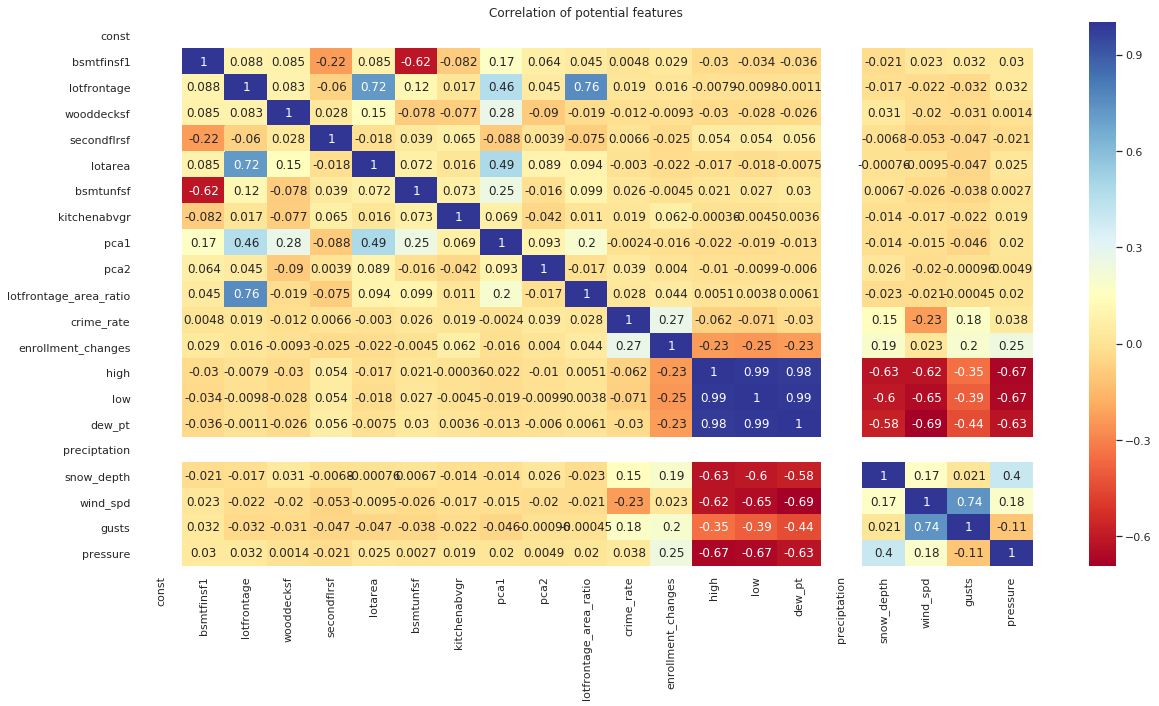

In [0]:
# View Feature correlation
plt.figure(figsize=(20,10))
ax = sns.heatmap(X2.corr(), cmap='RdYlBu', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation of potential features')

In [0]:
# Strong positive and negative corrleations in weather data indicate potential 
# need for PCA
P = X2[weather_data_cols]
P = scaler.fit_transform(P)
pca = PCA(n_components=1)
X2['pca'] = pca.fit_transform(P)

X2['saleprice'] = y
X2[['saleprice', 'pca'] + weather_data_cols].corr()

saleprice       pca      high  ...  wind_spd     gusts  pressure
saleprice      1.000000 -0.026970  0.012908  ... -0.053564 -0.060210  0.000632
pca           -0.026970  1.000000 -0.977950  ...  0.723157  0.472854  0.652042
high           0.012908 -0.977950  1.000000  ... -0.622071 -0.345604 -0.667528
low            0.014282 -0.985375  0.992513  ... -0.649187 -0.393410 -0.665312
dew_pt         0.019662 -0.985703  0.982804  ... -0.692606 -0.442664 -0.626101
preciptation        NaN       NaN       NaN  ...       NaN       NaN       NaN
snow_depth    -0.011977  0.626602 -0.625038  ...  0.168981  0.021420  0.403657
wind_spd      -0.053564  0.723157 -0.622071  ...  1.000000  0.738302  0.182138
gusts         -0.060210  0.472854 -0.345604  ...  0.738302  1.000000 -0.109916
pressure       0.000632  0.652042 -0.667528  ...  0.182138 -0.109916  1.000000

[10 rows x 10 columns]

## Test Model

In [0]:
# The columns 'wind_spd' and 'gusts' appear better correlated with the target, 
# however, for purposes of this test, PCA will be used.  
X2.drop(columns=['saleprice']+weather_data_cols, axis=1)

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, 
                                                      random_state=42)

test_model = Ridge(alpha=5.5)
test_model.fit(X2_train, y_train)

y_predict = test_model.predict(X2_test)

model_scorer(y_predict, y_test, 'Test Ridge Regressor (log)', ['rmse'])
model_scorer(np.expm1(y_predict), np.expm1(y_test), 'Test Ridge Regressor (dollars)',
             ['rmse'])

------- Test Ridge Regressor (log) Model Eval. -------
Root Mean Squared Error:  0.02613452669712126
------- Test Ridge Regressor (dollars) Model Eval. -------
Root Mean Squared Error:  4662.519415754746


# Conclusion

The test model provides very promising insights.  The inclusion of external weather, crime, and college enrollment results in, potentially, substantial improvements over the implemented model; a $20,000 error reduction.

Potential areas for improvement would be the specificity of time and date.  The precision of weather data is based on the data available.  In other words, only monthly data was used because the precision of sales date data was a month.  Additionally, differences in weather over a distance of 30 miles could impact the model's predictions.  

This test model asserts a general crime rate statistic for Ames, Iowa as a whole instead of targeting specific neighbood crime rates.  The ability of the model predictions to account for crime rates according to specific neighborhoods may also improve model performance.

More specific domain knowledge would be useful in determining the application of the model results. However, consideration of appraisals, loan value determination, and negotiation strategies can be greatly enhanced.